# Lab 2: Supervised Learning

In this lab, we prepare our Kiva data for a linear model, partake in additional exploratory analysis in order to engineer explanatory features that attempt to answer a question we are interested in: 

*What drives the loan amount requested by KIVA borrowers? * 

In the language of Module 1, our outcome feature is **loan_amount**. 

Here's a look ahead at what we'll be doing in this notebook: 

1. Load data and packages 

2. Feature engineering and selection

## **If you haven't already, please run through Notebook 1!**  You need the final ouput df_module_1.csv. You also need to pip install geopy in your terminal.

As a reminder, we had 3 raw data files (loans_full, loans_detail, and loans_partner_details). In Notebook 1 module_1_exploratory_analysis_with_solutions, we merged these data files and created new variables to form the data frame "df_module_1", we exported it as df_module_1.csv. We will use this dataframe now. 

First, we will load the packages we need for this section, and our data. 

In [2]:
## Import packages

import pandas as pd
import numpy as np
from datetime import datetime
from ggplot import *
from bs4 import BeautifulSoup
import re as re
import types
import seaborn as sns
%matplotlib inline

# packages for checking assumptions
from scipy import stats as stats

import matplotlib.pyplot as plt
import time
plt.style.use('bmh') 

#package for location features, if you do not already have this and it throws an error run pip install geopy from your
#terminal
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# the command below means that the output of multiple commands in a cell will be output at once.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
# the command below tells jupyter to display up to 100 columns, this keeps everything visible
pd.set_option('display.max_columns', 100)
pd.set_option('expand_frame_repr', True)

In [5]:
# Read in data
data_path = '~/AnacondaProjects/intro_to_machine_learning/data/'
df = pd.read_csv(data_path+'df_module_1.csv', low_memory=False)
df = pd.read_csv(data_path+'province_counties_KE.csv', low_memory=False)
# Read in data
data_path = '~/AnacondaProjects/intro_to_machine_learning/data/'
df = pd.read_csv(data_path+'df_module_1.csv', low_memory=False)

In [6]:
len(df.index)

118316

## Remove Loan Amount Outliers

In the exploratory module we introduced the concept of outliers and showed why it might be important to remove outlier loan amounts. Outliers are not strictly defined, but here, we suggest that a reasonable definition of an outlier is an observation that falls outside 3 standard deviations from the mean. In laymans terms, this means that an outlier is on the very tail end of a distribution. For a more rigorous definition of a standard deviation, read [here](http://mathworld.wolfram.com/Outlier.html).

Our data is very skewed by several extreme loan amount outliers. Now that we are considering a linear regression model, we should revisit removing our loan_amount outliers completely since they will cause bias in our results.

First, we look at the distribution of loans with outliers included.

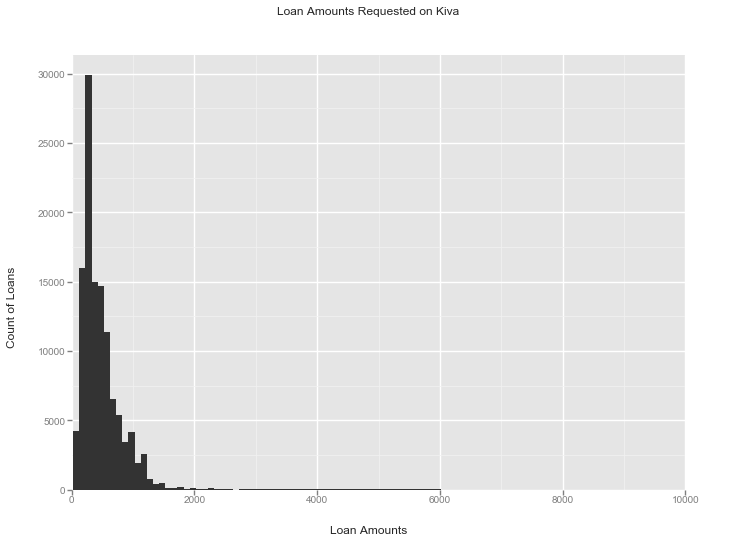

<ggplot: (-9223372036556260650)>

In [7]:
ggplot(df, aes(x='loan_amount')) + geom_histogram(binwidth=100, fill="blue") + xlim(0, 10000) + \
ggtitle("Loan Amounts Requested on Kiva") + xlab("Loan Amounts") + ylab("Count of Loans")

We first analyze the implications of removing outliers by creating a new dataframe without outliers. We call this df_removed_outliers. We can immediately see that the data is less skewed. This suggests we should remove outliers from our df dataframe permanently.

In [8]:
# dataset without outliers
df_removed_outliers=df[(((df['loan_amount']-df['loan_amount'].mean())/(df['loan_amount'].std())).abs()<3)] 

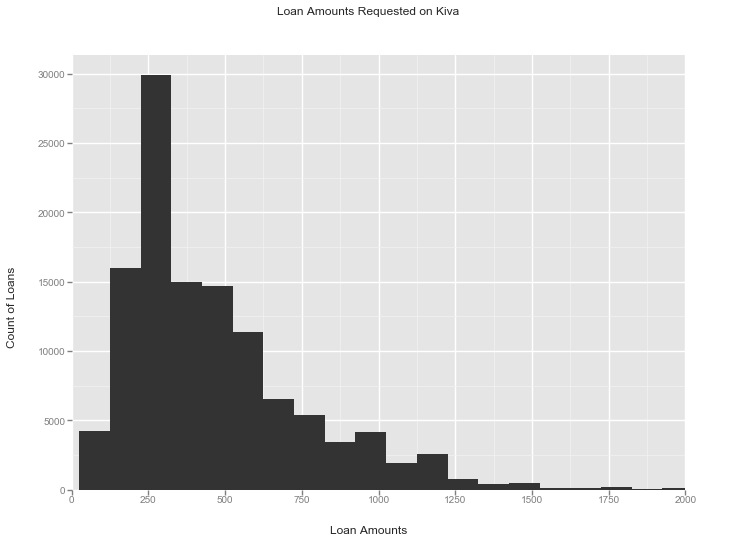

<ggplot: (282579078)>

In [9]:
ggplot(df_removed_outliers, aes(x='loan_amount')) + geom_histogram(binwidth=100, fill="blue") + xlim(0, 2000) + \
ggtitle("Loan Amounts Requested on Kiva") + xlab("Loan Amounts") + ylab("Count of Loans")

We should also examine what these outliers are to make sure they make sense excluding. We can see from the sample below that many of the biggest loans are for education grants. However, since so many of our loans are for $250, we conclude that the outliers are not representative of the typical Kiva borrower. But which loan should we exclude? Using the metric of standard deviation, it appears that many of the outliers as defined by those that lie outside the standard deviation are in fact for reasonable amounts. It is not clear we should simply exclude all of these loans.

In [10]:
outliers=df[~(((df['loan_amount']-df['loan_amount'].mean())/(df['loan_amount'].std())).abs()<3)] 

In [11]:
outliers.head(2)

,Unnamed: 0,Unnamed: 0.1,activity,basket_amount,bonus_credit_eligibility,borrowers,currency_exchange_loss_amount,description.languages,description.texts.en,description.texts.es,description.texts.fr,description.texts.ru,funded_amount,funded_date,id,image.id,image.template_id,journal_totals.bulkEntries,journal_totals.entries,lender_count,loan_amount,location.country,location.country_code,location.geo.level,location.geo.pairs,location.geo.type,location.town,name,partner_id,payments,planned_expiration_date,posted_date,sector,status,tags,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,terms.local_payments,terms.loss_liability.currency_exchange,terms.loss_liability.currency_exchange_coverage_rate,terms.loss_liability.nonpayment,terms.repayment_interval,terms.repayment_term,terms.scheduled_payments,themes,translator.byline,translator.image,use,video.id,video.thumbnailImageId,video.title,video.youtubeId,borrower_count,partner_average_loan_size_percent_per_capita_income,partner_charges_fees_and_interest,partner_countries,partner_currency_exchange_loss_rate,partner_default_rate,partner_default_rate_note,partner_delinquency_rate,partner_delinquency_rate_note,partner_image.id,partner_image.template_id,partner_loans_at_risk_rate,partner_loans_posted,partner_name,partner_portfolio_yield,partner_portfolio_yield_note,partner_profitability,partner_rating,partner_social_performance_strengths,partner_start_date,partner_status,partner_total_amount_raised,partner_url,posted_datetime,planned_expiration_datetime,funded_datetime,dispursal_datetime,dispersal_date,posted_year,number_of_loans,gender
2446,2446,76,Cereals,0.0,False,"[{'first_name': 'Emmy', 'last_name': '', 'gend...",NaN,['en'],Emmy would be characterized by her neighbours ...,NaN,NaN,NaN,0,NaN,1290670,2514887,1,0,0,0,2825,Kenya,KE,town,1 38,point,Bomet,Emmy,156.0,[],2017-06-06,2017-05-07,Food,fundraising,"[{'name': '#Woman Owned Biz'}, {'name': '#Pare...",290000.0,KES,2017-04-29T07:00:00Z,2825,"[{'due_date': '2017-05-29T07:00:00Z', 'amount'...",shared,0.1,lender,Monthly,20,"[{'due_date': '2017-07-01T07:00:00Z', 'amount'...",NaN,NaN,NaN,to buy cereals.,NaN,NaN,NaN,NaN,1,49.6,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.431935,2.575299,NaN,2.536684,NaN,1834079,1,24.200354,18150,Juhudi Kilimo,33.0,NaN,-7.1,2.0,"[{'id': 1, 'name': 'Anti-Poverty Focus', 'desc...",2010-01-15T20:20:17Z,active,7705925,http://www.juhudikilimo.com/,2017-05-07 21:10:03,2017-06-06 21:10:03,NaN,2017-04-29 07:00:00,2017-04-29,2017,1,Female
2665,2665,724,Higher education costs,NaN,False,"[{'first_name': 'Emma', 'last_name': '', 'gend...",NaN,['en'],"Greetings from Nairobi, Kenya! <br /><br />Thi...",NaN,NaN,NaN,3375,2017-05-01,1283742,2505410,1,0,0,119,3375,Kenya,KE,town,-1.283333 36.816667,point,Nairobi,Emma,156.0,[],2017-05-30,2017-04-30,Education,funded,"[{'name': '#Parent'}, {'name': '#Schooling'}, ...",347200.0,KES,2017-04-23T07:00:00Z,3375,[],shared,0.1,lender,NaN,62,[],['Higher Education'],Usha Schmit,2047322.0,to pay for a course in human resource managment.,NaN,NaN,NaN,NaN,1,49.6,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.431935,2.575299,NaN,2.536684,NaN,1834079,1,24.200354,18150,Juhudi Kilimo,33.0,NaN,-7.1,2.0,"[{'id': 1, 'name': 'Anti-Poverty Focus', 'desc...",2010-01-15T20:20:17Z,active,7705925,http://www.juhudikilimo.com/,2017-04-30 02:20:02,2017-05-30 02:20:02,2017-05-01 14:38:23,2017-04-23 07:00:00,2017-04-23,2017,1,Female


For now, let's be a little conservative. Instead of removing all observations that fall outside a standard deviation, let's simply restrict our analysis to loans below $6000. We can always come back and restrict it further using our outlier definition. We have commented out the code below, so we can come back and change what loans we exclude from our analysis.

In [12]:
# remove outliers from dataframe
#df=df[(((df['loan_amount']-df['loan_amount'].mean())/(df['loan_amount'].std())).abs()<3)] 

In [13]:
df=df[df['loan_amount']<=6000]

In [14]:
len(df)

118199

In [15]:
print(df.describe())

         Unnamed: 0   Unnamed: 0.1  basket_amount  \
count  118199.00000  118199.000000     942.000000   
mean    59142.69641   64399.551942       0.185775   
std     34155.11655   38166.408127       2.148199   
min         0.00000       0.000000       0.000000   
25%     29557.50000   29555.500000       0.000000   
50%     59157.00000   66501.000000       0.000000   
75%     88706.50000   98264.500000       0.000000   
max    118315.00000  127899.000000      25.000000   

       currency_exchange_loss_amount  funded_amount            id  \
count                   15675.000000  118199.000000  1.181990e+05   
mean                        6.792162     460.031811  7.095884e+05   
std                         9.857512     394.928783  3.413792e+05   
min                         0.010000       0.000000  2.510000e+02   
25%                         1.220000     250.000000  4.198620e+05   
50%                         3.490000     350.000000  6.976380e+05   
75%                         8.260000   

In [16]:
df.to_csv(data_path+'df_module_2_w_outliers.csv')

## Feature Engineering and Selection

When we try to think of features that will predict loan_amount, we are doing feature engineering. We may not end up using all the features we create, but it is an important extension of exploratory analysis. The key difference between feature engineering and exploratory analysis is that we now have a defined question in mind: "What drives the loan amount requested by KIVA lenders?"

We will also be making decisions about our final set of features along the way. Too few features results in low predictive power, and too many features may violate the assumption that there is no multicollinearity present (for more on multicollinearity, refer back to lecture slides!) Carefully choosing what features you think will be powerful enough to predict your outcome feature is difficult, and is subject to data availability and integrity problems. In short, it deserves your thoughtful consideration! 

*You should always make these preliminary checks in any feature you create to make sure it is what you expect!* 

## How do you get started with feature engineering and selection?

Machines still need us! Our understanding or the world and intuition about cause and effect allow us to extract meaning from raw data and structure data in a more powerful way.

### Feature engineering is a very creative process so start by asking yourself:

### What would motivate the loan amount I request?**

What comes to mind? Probably the most obvious response is the use case you have in mind. Dig deeper, what is that use case driven by:
- your job.
- where you live. What are local prices like? A loan in a high income urban area is likely to be higher on average than a loan in small rural town.
- the time of the year. Maybe you need to supplement your cash flow at certain points during the year?
- Do you have children? Your demographics (age, gender)
- Who is lending to you. Are they charging a high interest? High interest may make you hesitate to take out a big loan.
- The standards of the loan partner. If they have lax standards, and are offering you a big loan with little collatoral needed, you may be tempted to accept a higher amount. 
- Have you taken a loan before? Did you have a good experience of KIVA?

These are some initial thoughts, but there could be many more features you can think of. In fact, the beauty of feature engineering is that diverse perspectives often bring out powerful new discoveries in the data.

## Step 1: Demographic features.

## Gender

We do have one demographic feature we will be retunring to from our initial exploratory analysis. We know that there appears to be a relationship between gender and loan_amount requested. On average, women appear to request lower loan amounts than men.

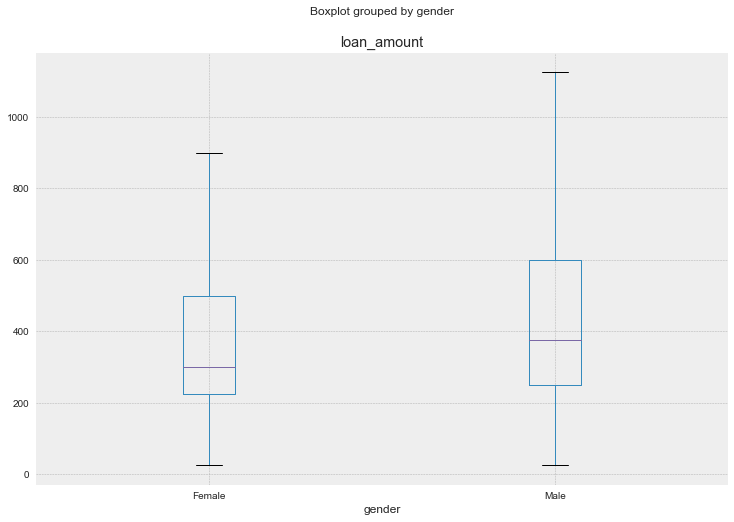

In [17]:
df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='gender', showfliers=False, figsize=(12,8))

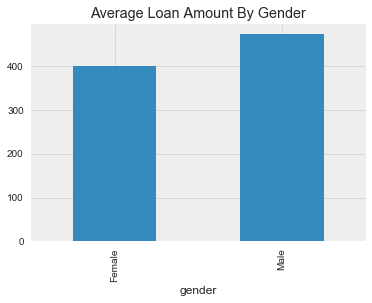

In [18]:
df[df['borrower_count'] == 1].groupby('gender')['loan_amount'].mean().plot(kind="bar", title="Average Loan Amount By Gender")

## Status and Age

In the first module, we only considered gender as a demographic feature. However, there could be other demographic features that influence the loan amount you request. 


Let's start with a broad exploration of of the description field. This will help showcase how to manipulate string data, and will also allow us to extract some interesting age and status related features.

In the cell below we use Numpy's  [where](https://docs.scipy.org/doc/numpy/reference/generated/numpy.where.html) function  and Panda's [str.contains](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.contains.html) to create the widowed", "kids", and "elderly" features. 

We are using Numpy's filter the data such that we are only creating a Boolean variable for those observations in which we find the strings of interest - in this case, any variation of the words widow, and any indication of children. Note that we try to be inclusive by testing for variations like "daughter" and "son."

In [19]:
## Whether or not the borrower is widowed
#  Note the str.contains function

df['widowed'] = np.where(df['description.texts.en'].str.contains("widowed|widow", na=0)==True, 1, 0)

## Whether or not the borrower has children, notice we look for many variants of the word.
df['kids'] = np.where(df['description.texts.en'].str.contains("kids|child|children|kid|son|daughter|mother|father|parents", na=0) ==True,1,0)
## Whether or not the borrower is elderly
df['elderly'] = np.where(df['tags'].str.contains("#Elderly", na=0) ==True, 1, 0)


We create the features above because we had the hypothesis that certain demographic features may drive the loan amount requested. However, all these new features face a data scarcity problem. We can see this by looking at the value_counts() of each new feature. 

In [20]:
df['widowed'].value_counts()
df['kids'].value_counts()
df['elderly'].value_counts()

0    115621
1      2578
Name: widowed, dtype: int64

1    101202
0     16997
Name: kids, dtype: int64

0    112723
1      5476
Name: elderly, dtype: int64

The words are only contained in a handful of descriptions. Features with little variance so it will quickly drop out in any model we try it in. However, kids seems really promising.

**Data scarcity** reduces the utility of the new field as an explanatory feature because if most observations of the feature are missing, it will not be a good discriminator in predicting loans. To understand this, think about if we are trying to predict nationality using accent. There are 20 nationalities present, but everyone has the same accent. Accent will not be useful anymore in getting us closer to seperating nationalities, we should instead rely on other features. 

Despite the weakness of these features, this has still been a useful process. Many steps in feature development involve creating features that will not ultimately be used. It is through creative exploration that we will eventually pinpoint our winning features. In fact, this has given us the idea to more systematically extract age.

Below, we do one final validation step and plot the features we just extracted. You can see in the boxplots below that both elderly and widowed fo not differ much in the distribution of loan amount. That is another strong hint not to include them as features in our final model. Any good explanatory variable will cause variance in the explanatory variable.

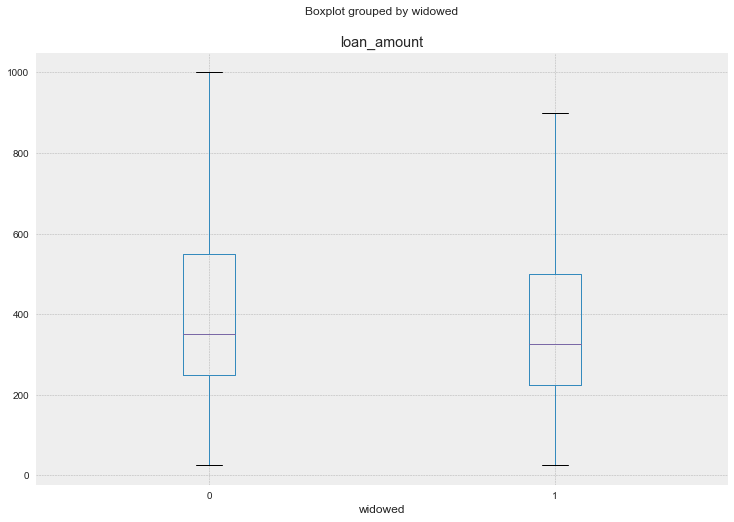

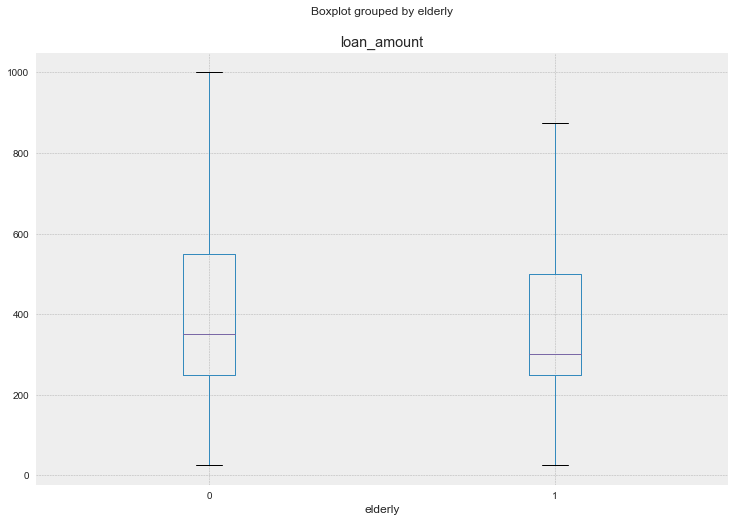

In [21]:
df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='widowed', showfliers=False, figsize=(12,8))

df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='elderly', showfliers=False, figsize=(12,8))

However, it is worth taking a closer look at kids. This field still faces a data scarcity issue, but we can see that lenders with kids do have a more narrow distribution than lenders without. It appears that parents are less likely to take high value loans.

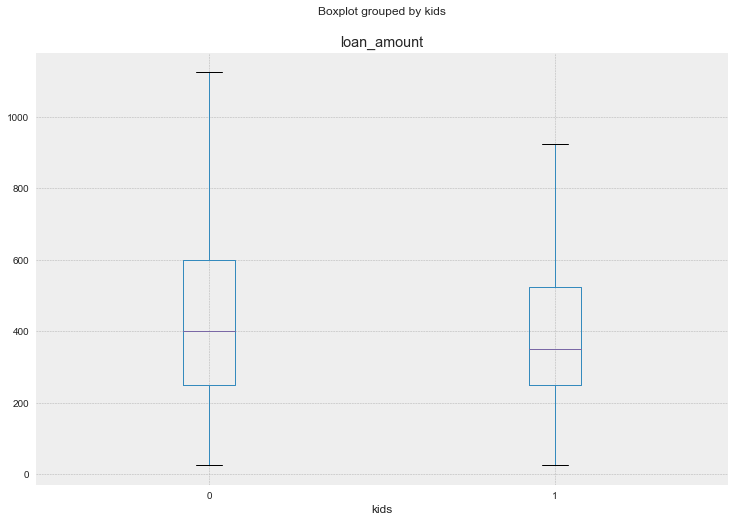

In [22]:
df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='kids', showfliers=False, figsize=(12,8))

## Tags

In the dataset we have a really interesting field called tags. You can take a look at the field below. Let's create a feature called number of tags.

In [23]:
df = pd.read_csv(data_path+'df_module_2_w_outliers.csv', low_memory=False)

In [24]:
df['tags'].head(2)

0    [{'name': '#Woman Owned Biz'}, {'name': '#Pare...
1                                                   []
Name: tags, dtype: object

In [25]:
df['num_tags'] = df['tags'].apply(lambda x: x.count(','))

In [26]:
df['num_tags'].value_counts()

0     73716
2     13059
1     11285
3      8877
4      5414
5      2524
6      1813
7      1123
8       332
9        45
10       10
11        1
Name: num_tags, dtype: int64

Let's plot the data to get a feel for the relationship.

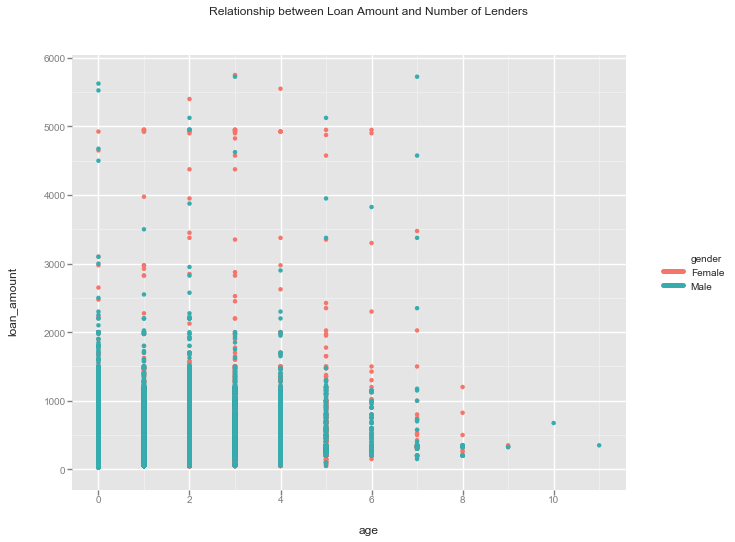

<ggplot: (-9223372036572202773)>

In [27]:
ggplot(df[(df['borrower_count'] == 1)], aes(x = 'num_tags', y = 'loan_amount', color="gender")) + geom_point() + \
ggtitle("Relationship between Loan Amount and Number of Lenders") + xlab("age") + ylab("loan_amount")

We can see there is a data scarcity issue in the number of loans with more than 8 tags. We may want to consider bucketing this before we use it as a feature. Now, let's take a closer look and extract the tags as features.

In [28]:
df['tags'].value_counts().index[:10]

Index(['[]', '[{'name': '#Woman Owned Biz'}, {'name': '#Parent'}]',
       '[{'name': 'user_favorite'}]',
       '[{'name': '#Woman Owned Biz'}, {'name': '#Parent'}, {'name': '#Repeat Borrower'}]',
       '[{'name': '#Parent'}]', '[{'name': '#Woman Owned Biz'}]',
       '[{'name': '#Woman Owned Biz'}, {'name': '#Parent'}, {'name': '#Schooling'}]',
       '[{'name': '#Parent'}, {'name': '#Repeat Borrower'}]',
       '[{'name': 'volunteer_pick'}]',
       '[{'name': '#Woman Owned Biz'}, {'name': '#Vegan'}, {'name': '#Parent'}]'],
      dtype='object')

Lets create individual features for tags that we think may be interesting and hot code the reponse. This means that value of that features = 1 if the tag was present and 0 if the tag was not present.

In [29]:
tag_vals = ["#Woman Owned Biz", "#Parent", "user_favorite", "#Repeat Borrower", "#Schooling", "volunteer_pick", "#Vegan", "volunteer_like","#Animals", "#Eco-friendly", "#Technology"]
for tag in tag_vals:
    if tag not in df.columns:
        df['tag_'+str(tag)] = df['tags'].apply(lambda x: 1 if tag in x else 0)

In [30]:
df['tag_#Woman Owned Biz'].value_counts()
df['tag_#Parent'].value_counts()
df['tag_#Repeat Borrower'].value_counts()
df['tag_#Schooling'].value_counts()
df['tag_#Parent'].value_counts()
df['tag_volunteer_pick'].value_counts()
df['tag_#Vegan'].value_counts()
df['tag_volunteer_like'].value_counts()
df['tag_#Animals'].value_counts()
df['tag_#Eco-friendly'].value_counts()
df['tag_#Technology'].value_counts()

0    95950
1    22249
Name: tag_#Woman Owned Biz, dtype: int64

0    83624
1    34575
Name: tag_#Parent, dtype: int64

0    104963
1     13236
Name: tag_#Repeat Borrower, dtype: int64

0    106814
1     11385
Name: tag_#Schooling, dtype: int64

0    83624
1    34575
Name: tag_#Parent, dtype: int64

0    115321
1      2878
Name: tag_volunteer_pick, dtype: int64

0    107367
1     10832
Name: tag_#Vegan, dtype: int64

0    116259
1      1940
Name: tag_volunteer_like, dtype: int64

0    111271
1      6928
Name: tag_#Animals, dtype: int64

0    108511
1      9688
Name: tag_#Eco-friendly, dtype: int64

0    110792
1      7407
Name: tag_#Technology, dtype: int64

We can immediately see that some tags are more useful then others because of coverage. The #parent tag, # repeat borrower tag, #women owned biz tag all look really useful. Let's take a look at the box plots for all of them.

### Women Owned Business

We can see from the box plot that women owned businesses actually request higher amounts on average. However, the boxplot tells a more complete story, we can tell that while the average is higher the range is more narrow.

In [31]:
df['tag_#Woman Owned Biz'].value_counts()

0    95950
1    22249
Name: tag_#Woman Owned Biz, dtype: int64

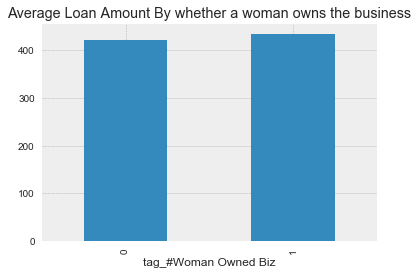

In [32]:
df[df['borrower_count'] == 1].groupby('tag_#Woman Owned Biz')['loan_amount'].mean().plot(kind="bar", title="Average Loan Amount By whether a woman owns the business")

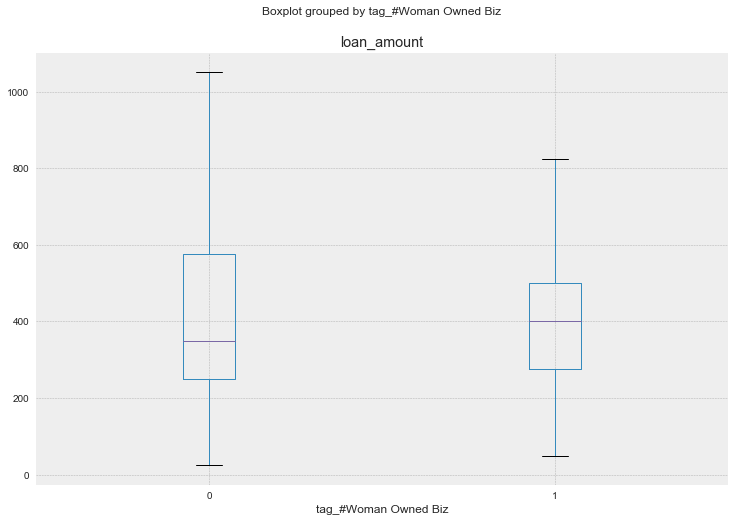

In [33]:
df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='tag_#Woman Owned Biz', showfliers=False, figsize=(12,8))

## Parent

Below, the tag tells us that parents request a higher amount then those that do not have children. This seems to be the opposite of what we learnt when we look at our handcrafted kids feature based upon our string match.


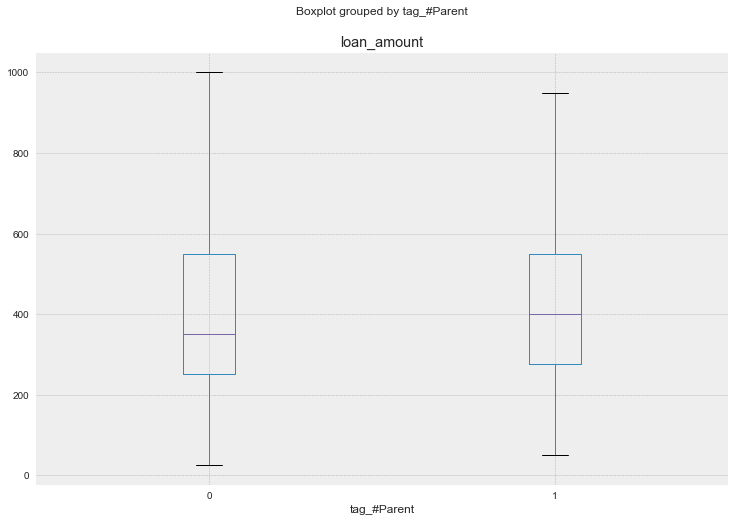

In [34]:
df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='tag_#Parent', showfliers=False, figsize=(12,8))

Our handcrafted feature has much higher coverage in the dataset. Let us try and combine the features because there appear to be many loans that were not tagged parent that we caught using our text match.

In [35]:
df['tag_#Parent'].value_counts()
df['kids'].value_counts()

0    83624
1    34575
Name: tag_#Parent, dtype: int64

KeyError: 'kids'

In [ ]:
df['parent'] = np.where(df['tag_#Parent']==1, df['tag_#Parent'], df['kids'])

In [ ]:
df['parent'].value_counts()

Now, let's plot the average. Below, with better coverage we seem to be telling a very different story. The average amount and distribution of loan amounts requested by parents appears to be lower.

In [ ]:
df[df['borrower_count'] == 1].groupby('parent')['loan_amount'].mean().plot(kind="bar", title="Average Loan Amount By whether a woman owns the business")

In [36]:
df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='parent', showfliers=False, figsize=(12,8))

KeyError: 'parent'

## Repeat Borrower

Now let's look at repeat borrowers. There are ~13,000 repeat borrowers in our dataset. A strong hypothesis could be that if you are a returning borrower you may request more since you have already demonstrated ability to pay back.

In [38]:
df['tag_#Repeat Borrower'].value_counts()

0    104963
1     13236
Name: tag_#Repeat Borrower, dtype: int64

In [39]:
## Whether or not the borrower is widowed
#  Note the str.contains function

df['widowed'] = np.where(df['description.texts.en'].str.contains("widowed|widow", na=0)==True, 1, 0)

## Whether or not the borrower has children, notice we look for many variants of the word.
df['kids'] = np.where(df['description.texts.en'].str.contains("kids|child|children|kid|son|daughter|mother|father|parents", na=0) ==True,1,0)
## Whether or not the borrower is elderly
df['elderly'] = np.where(df['tags'].str.contains("#Elderly", na=0) ==True, 1, 0)

df['repeat_borrower'] = np.where(df['tags'].str.contains("#Repeat Borrower", na=0) ==True, 1, 0)



In [40]:
df['repeat_borrower'].value_counts()

0    104963
1     13236
Name: repeat_borrower, dtype: int64

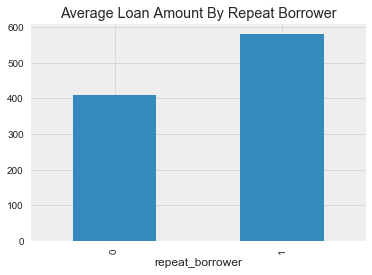

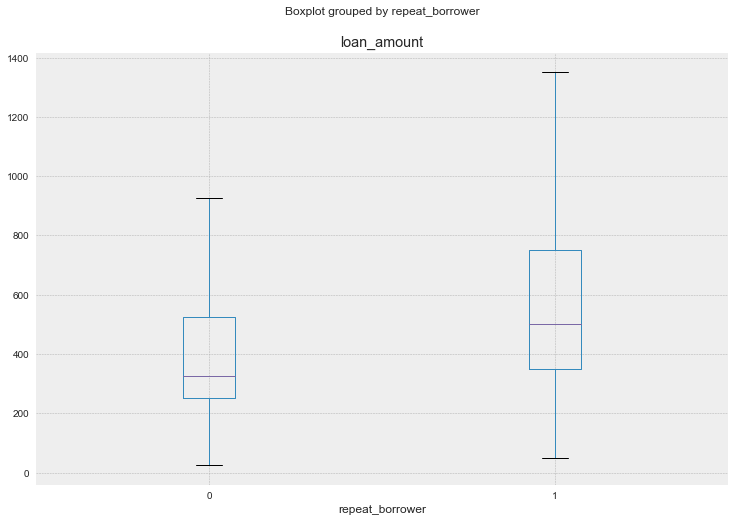

In [41]:
df[df['borrower_count'] == 1].groupby('repeat_borrower')['loan_amount'].mean().plot(kind="bar", title="Average Loan Amount By Repeat Borrower")

df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='repeat_borrower', showfliers=False, figsize=(12,8))

There certainly seems to be a strong relationship here! We should definately include this feature.

## Schooling

In [42]:
df['tag_#Schooling'].value_counts()

0    106814
1     11385
Name: tag_#Schooling, dtype: int64

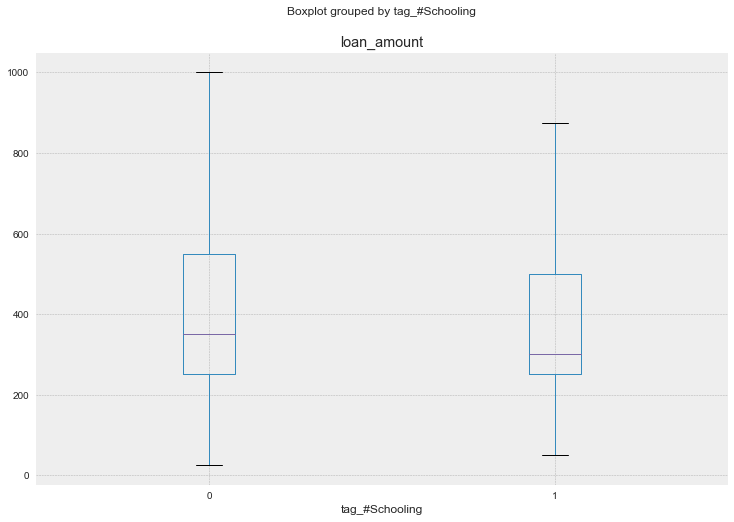

In [43]:
df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='tag_#Schooling', showfliers=False, figsize=(12,8))

## Marital Status

Before we move on, we read through a few descriptions and realize many loans mention whether the applicant is married. We decide to take a look at this feature by doing a text search for the word married, husband or wife.

In [44]:
## Whether or not the borrower is married
df['married'] = np.where(df['description.texts.en'].str.contains("married|husband|wife", na=0)==True, 1, 0)

In [45]:
df[df['married']==True].head(2)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,activity,basket_amount,bonus_credit_eligibility,borrowers,currency_exchange_loss_amount,description.languages,description.texts.en,description.texts.es,description.texts.fr,description.texts.ru,funded_amount,funded_date,id,image.id,image.template_id,journal_totals.bulkEntries,journal_totals.entries,lender_count,loan_amount,location.country,location.country_code,location.geo.level,location.geo.pairs,location.geo.type,location.town,name,partner_id,payments,planned_expiration_date,posted_date,sector,status,tags,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,terms.local_payments,terms.loss_liability.currency_exchange,terms.loss_liability.currency_exchange_coverage_rate,terms.loss_liability.nonpayment,terms.repayment_interval,terms.repayment_term,terms.scheduled_payments,themes,translator.byline,translator.image,...,video.title,video.youtubeId,borrower_count,partner_average_loan_size_percent_per_capita_income,partner_charges_fees_and_interest,partner_countries,partner_currency_exchange_loss_rate,partner_default_rate,partner_default_rate_note,partner_delinquency_rate,partner_delinquency_rate_note,partner_image.id,partner_image.template_id,partner_loans_at_risk_rate,partner_loans_posted,partner_name,partner_portfolio_yield,partner_portfolio_yield_note,partner_profitability,partner_rating,partner_social_performance_strengths,partner_start_date,partner_status,partner_total_amount_raised,partner_url,posted_datetime,planned_expiration_datetime,funded_datetime,dispursal_datetime,dispersal_date,posted_year,number_of_loans,gender,num_tags,tag_#Woman Owned Biz,tag_#Parent,tag_user_favorite,tag_#Repeat Borrower,tag_#Schooling,tag_volunteer_pick,tag_#Vegan,tag_volunteer_like,tag_#Animals,tag_#Eco-friendly,tag_#Technology,widowed,kids,elderly,repeat_borrower,married
0,0,0,0,Farming,0.0,False,"[{'first_name': 'Evaline', 'last_name': '', 'g...",NaN,['en'],Evaline is a married lady aged 44 years old an...,NaN,NaN,NaN,0,NaN,1291548,2516002,1,0,0,0,500,Kenya,KE,town,-0.583333 35.183333,point,litein,Evaline,386.0,[],2017-06-08,2017-05-09,Agriculture,fundraising,"[{'name': '#Woman Owned Biz'}, {'name': '#Pare...",50000.0,KES,2017-04-03T07:00:00Z,500,"[{'due_date': '2017-05-10T07:00:00Z', 'amount'...",shared,0.1,lender,Monthly,14,"[{'due_date': '2017-07-01T07:00:00Z', 'amount'...",NaN,Julie Keaton,892591.0,...,NaN,NaN,1,0.0,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.120642,0.0,NaN,7.017031,NaN,1592272,1,21.165398,1948,Kenya ECLOF,40.3,NaN,2.54,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2014-05-29T13:30:02Z,active,863375,http://www.eclof-kenya.org/,2017-05-09 00:40:03,2017-06-08 00:40:03,NaN,2017-04-03 07:00:00,2017-04-03,2017,1,Female,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,1,1,1,Furniture Making,0.0,False,"[{'first_name': 'Julias', 'last_name': '', 'ge...",NaN,['en'],Aged 42 years is a man by the name of Julias. ...,NaN,NaN,NaN,0,NaN,1291532,2515992,1,0,0,0,500,Kenya,KE,town,0.566667 34.566667,point,Bungoma,Julias,386.0,[],2017-06-08,2017-05-09,Manufacturing,fundraising,[],50000.0,KES,2017-04-03T07:00:00Z,500,"[{'due_date': '2017-05-09T07:00:00Z', 'amount'...",shared,0.1,lender,Monthly,14,"[{'due_date': '2017-07-01T07:00:00Z', 'amount'...",NaN,Morena Calvo,1832928.0,...,NaN,NaN,1,0.0,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.120642,0.0,NaN,7.017031,NaN,1592272,1,21.165398,1948,Kenya ECLOF,40.3,NaN,2.54,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2014-05-29T13:30:02Z,active,863375,http://www.eclof-kenya.org/,2017-05-09 00:30:05,2017-06-08 00:30:05,NaN,2017-04-03 07:00:00,2017-04-03,2017,1,Male,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


The difference in average amount is not that impressive between married and unmarried borrowers, however, when we look at the boxplots we see a richer story about the difference in distribution. Married borrowers have a narrower range.

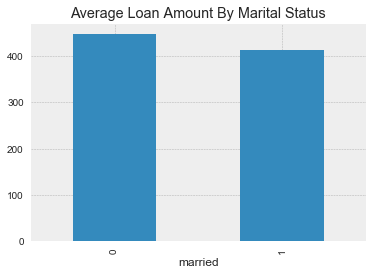

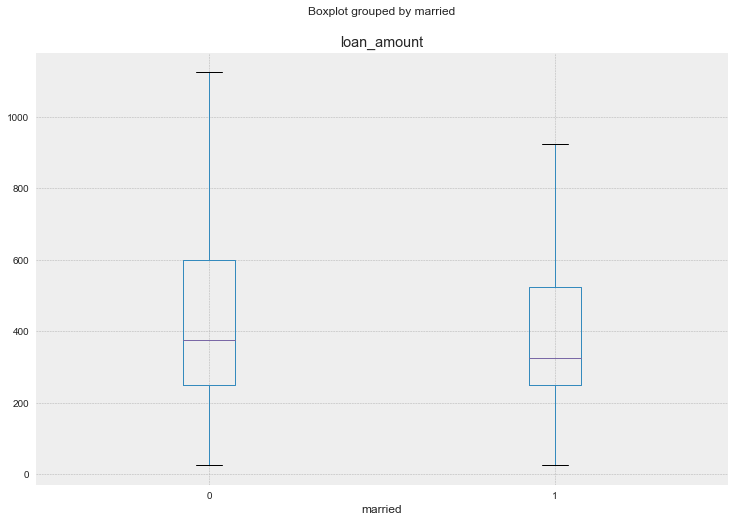

In [46]:
df[df['borrower_count'] == 1].groupby('married')['loan_amount'].mean().plot(kind="bar", title="Average Loan Amount By Marital Status")

df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='married', showfliers=False, figsize=(12,8))

We were right to take a look at it! Married has good coverage and it seems that lenders who are married typically request smaller loans. This suggests lenders who are married are willing to tolerate less risk. 

In the last class we discussed reasons that a woman might be requesting a lower loan amount. One of the hypotheses that came up was that a woman might need to ask permission from her husband to request a loan if she is married. Now we have a feature for whether someone is married we can put this to the test! 

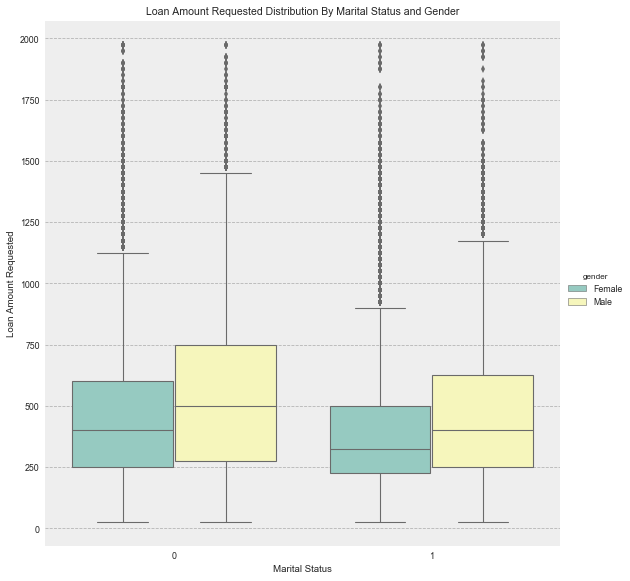

In [47]:
plt.figure(figsize=(8, 20))

sns.set_context("paper", font_scale=1.1, rc={"lines.linewidth": 1.1})

sns.factorplot(x="married", y="loan_amount", hue="gender", palette="Set3", data=df[df['loan_amount']<2000], kind="box",orient="v", size=8, aspect=1)
plt.title('Loan Amount Requested Distribution By Marital Status and Gender')
plt.xlabel('Marital Status')
plt.ylabel('Loan Amount Requested')

In fact we can see from the boxplot above that both married men and women tend to request lower amounts. Women consistently appear to request lowers amounts in both the married and unmarried groupings. This reduces the strength of that hypothesis as one of the key reasons women request lower amounts.

The marriage field has turned out to be very interesting and we will definately include it in our model!


#### A note of caution!

While we are pleased with the results above, let's be aware that free form text is always going to be a problematic feature. For example, there may be inconsistencies in what people choose to say about themselves. We can fairly sure that when a person says they are married thay are in fact married, but if they don't it may just be by ommission. In other words, they may be married but choose not to report it on their loan application (there is no requirement they do so!).

The lack of a consistent way data is reported is a problem you will face again and again in data science. Often, when we find compelling results like the boxplot above it is a strong signal we should push for more systematic collection of those fields. This could take the form of a questions asking about marital status that can already be responded to with 'single', 'married', 'divorced'.

## Age and number of children

### More systematic string matching.

Our work with string matching has given us the idea to extract age and also number of children in a more systematic way. In the cells below, we parse out the **age** of the user by doing the following:

1. Importing a CSV mapping of age strings that appear in the Kiva description field (e.g. "2 years") to the integer counterparts (e.g. 2). 
2. We then define a function to check for each of these string values within the `description.texts.en` field of our main dataframe. If a match is found, we append that string value to a new list, "age", which we create at the start of the funtion. If no match is found, we append a blank string. When the function has completed, we have a list the same length of our main dataframe, with the corresponding age string value for each observation (e.g. "2 years" or " " if there is no age value available)
    1. We use functions from the [regular expression package](https://docs.python.org/2/library/re.html) to perform the string searches within the `description.texts.en`. Specifically, we use `re.compile` and  `re.findall` functions to first compile all possible age strings of interest, and then find all instances of the corresponding string.
3. We then create a new column in our main dataframe, "age", which is simply the list we created in step 2.
4. Finally, we perform a left join of our main dataframe with the CSV mapping, to map the string versions of age with their integer counterparts.



In [48]:
lookup_tags = pd.read_csv(data_path+'tags.csv')

In [49]:
lookup_tags.head(2)

,age,age_int,children_1,children_2,children_int
0,1 years,1,one child,1 child,1.0
1,2 years,2,two children,2 children,2.0


In [50]:
## Age of borrower and number of children

# define a function that performs a loop that parses out all words, 
#  finds age and number of children match and creates a list that is return at the end of the function

def text_search(tag):
    #creates empty lists that are then added to in loop
    number=[]
    flag = tag.astype(str)
    match=flag.tolist()
    match = re.compile(r'\b(?:%s)\b' % '|'.join(match))
    for descr in df['description.texts.en']:
        try:
            if isinstance(descr, str):
                    if re.findall(match, descr):
                        match_0=re.findall(match,  descr)
                        match_1=re.findall(match,  descr)[:1]
                        word_1=" ".join(match_1)
                        number.append(word_1)
                    else:
                        number.append('')
        except:
            print('error')
            
    return(number)

In the cell below we write a small loop to go through each feature and search. Running this loop is fairly computationally expensive since it is doing a string match against every row of the data. You can expect it to take a few minutes to run. You can add other lists to the tags csv to extend the features you search for.

In [51]:
features=['age','children_1', 'children_2'] 

for feature in features:
        number= text_search(lookup_tags[feature])
        df[feature]=pd.DataFrame(number)

As always we take a look at our dataframe and check the length of the index to make sure our loop was successful. Then we join in the int fields in our imported tags so we can treat these fields as a numerical variable (you will see we have successfully created age_int and children_int).

In [52]:
df.head(2)
len(df.index)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,activity,basket_amount,bonus_credit_eligibility,borrowers,currency_exchange_loss_amount,description.languages,description.texts.en,description.texts.es,description.texts.fr,description.texts.ru,funded_amount,funded_date,id,image.id,image.template_id,journal_totals.bulkEntries,journal_totals.entries,lender_count,loan_amount,location.country,location.country_code,location.geo.level,location.geo.pairs,location.geo.type,location.town,name,partner_id,payments,planned_expiration_date,posted_date,sector,status,tags,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,terms.local_payments,terms.loss_liability.currency_exchange,terms.loss_liability.currency_exchange_coverage_rate,terms.loss_liability.nonpayment,terms.repayment_interval,terms.repayment_term,terms.scheduled_payments,themes,translator.byline,translator.image,...,partner_average_loan_size_percent_per_capita_income,partner_charges_fees_and_interest,partner_countries,partner_currency_exchange_loss_rate,partner_default_rate,partner_default_rate_note,partner_delinquency_rate,partner_delinquency_rate_note,partner_image.id,partner_image.template_id,partner_loans_at_risk_rate,partner_loans_posted,partner_name,partner_portfolio_yield,partner_portfolio_yield_note,partner_profitability,partner_rating,partner_social_performance_strengths,partner_start_date,partner_status,partner_total_amount_raised,partner_url,posted_datetime,planned_expiration_datetime,funded_datetime,dispursal_datetime,dispersal_date,posted_year,number_of_loans,gender,num_tags,tag_#Woman Owned Biz,tag_#Parent,tag_user_favorite,tag_#Repeat Borrower,tag_#Schooling,tag_volunteer_pick,tag_#Vegan,tag_volunteer_like,tag_#Animals,tag_#Eco-friendly,tag_#Technology,widowed,kids,elderly,repeat_borrower,married,age,children_1,children_2
0,0,0,0,Farming,0.0,False,"[{'first_name': 'Evaline', 'last_name': '', 'g...",NaN,['en'],Evaline is a married lady aged 44 years old an...,NaN,NaN,NaN,0,NaN,1291548,2516002,1,0,0,0,500,Kenya,KE,town,-0.583333 35.183333,point,litein,Evaline,386.0,[],2017-06-08,2017-05-09,Agriculture,fundraising,"[{'name': '#Woman Owned Biz'}, {'name': '#Pare...",50000.0,KES,2017-04-03T07:00:00Z,500,"[{'due_date': '2017-05-10T07:00:00Z', 'amount'...",shared,0.1,lender,Monthly,14,"[{'due_date': '2017-07-01T07:00:00Z', 'amount'...",NaN,Julie Keaton,892591.0,...,0.0,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.120642,0.0,NaN,7.017031,NaN,1592272,1,21.165398,1948,Kenya ECLOF,40.3,NaN,2.54,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2014-05-29T13:30:02Z,active,863375,http://www.eclof-kenya.org/,2017-05-09 00:40:03,2017-06-08 00:40:03,NaN,2017-04-03 07:00:00,2017-04-03,2017,1,Female,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,44 years,,6 children
1,1,1,1,Furniture Making,0.0,False,"[{'first_name': 'Julias', 'last_name': '', 'ge...",NaN,['en'],Aged 42 years is a man by the name of Julias. ...,NaN,NaN,NaN,0,NaN,1291532,2515992,1,0,0,0,500,Kenya,KE,town,0.566667 34.566667,point,Bungoma,Julias,386.0,[],2017-06-08,2017-05-09,Manufacturing,fundraising,[],50000.0,KES,2017-04-03T07:00:00Z,500,"[{'due_date': '2017-05-09T07:00:00Z', 'amount'...",shared,0.1,lender,Monthly,14,"[{'due_date': '2017-07-01T07:00:00Z', 'amount'...",NaN,Morena Calvo,1832928.0,...,0.0,True,"[{'iso_code': 'KE', 'region': 'Africa', 'name'...",0.120642,0.0,NaN,7.017031,NaN,1592272,1,21.165398,1948,Kenya ECLOF,40.3,NaN,2.54,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2014-05-29T13:30:02Z,active,863375,http://www.eclof-kenya.org/,2017-05-09 00:30:05,2017-06-08 00:30:05,NaN,2017-04-03 07:00:00,2017-04-03,2017,1,Male,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,42 years,two children,


118199

Finally, we map the integer fields unto our dataframe. That way we can decide whether to use number of children as a str feature or an int feature.

In [53]:
mydict = dict(zip(lookup_tags.children_1, lookup_tags.children_int))
df['children_int_1'] = df['children_1'].map(mydict)

mydict = dict(zip(lookup_tags.children_2, lookup_tags.children_int))
df['children_int_2'] = df['children_2'].map(mydict)

mydict = dict(zip(lookup_tags.age, lookup_tags.age_int))
df['age_int'] = df['age'].map(mydict)

In [54]:
df['children_int'] = df['children_int_1'].fillna(df['children_int_2'])
df['children_int']=df['children_int'].fillna(0)

We check out our dataframe and save our work below! So cool, we now have the number of children and the age in years where it is reported in the loan description.

In [55]:
df.to_csv(data_path+'df_module_2_w_outliers.csv')

In [56]:
df.head(2)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,activity,basket_amount,bonus_credit_eligibility,borrowers,currency_exchange_loss_amount,description.languages,description.texts.en,description.texts.es,description.texts.fr,description.texts.ru,funded_amount,funded_date,id,image.id,image.template_id,journal_totals.bulkEntries,journal_totals.entries,lender_count,loan_amount,location.country,location.country_code,location.geo.level,location.geo.pairs,location.geo.type,location.town,name,partner_id,payments,planned_expiration_date,posted_date,sector,status,tags,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,terms.local_payments,terms.loss_liability.currency_exchange,terms.loss_liability.currency_exchange_coverage_rate,terms.loss_liability.nonpayment,terms.repayment_interval,terms.repayment_term,terms.scheduled_payments,themes,translator.byline,translator.image,...,partner_default_rate,partner_default_rate_note,partner_delinquency_rate,partner_delinquency_rate_note,partner_image.id,partner_image.template_id,partner_loans_at_risk_rate,partner_loans_posted,partner_name,partner_portfolio_yield,partner_portfolio_yield_note,partner_profitability,partner_rating,partner_social_performance_strengths,partner_start_date,partner_status,partner_total_amount_raised,partner_url,posted_datetime,planned_expiration_datetime,funded_datetime,dispursal_datetime,dispersal_date,posted_year,number_of_loans,gender,num_tags,tag_#Woman Owned Biz,tag_#Parent,tag_user_favorite,tag_#Repeat Borrower,tag_#Schooling,tag_volunteer_pick,tag_#Vegan,tag_volunteer_like,tag_#Animals,tag_#Eco-friendly,tag_#Technology,widowed,kids,elderly,repeat_borrower,married,age,children_1,children_2,children_int_1,children_int_2,age_int,children_int
0,0,0,0,Farming,0.0,False,"[{'first_name': 'Evaline', 'last_name': '', 'g...",NaN,['en'],Evaline is a married lady aged 44 years old an...,NaN,NaN,NaN,0,NaN,1291548,2516002,1,0,0,0,500,Kenya,KE,town,-0.583333 35.183333,point,litein,Evaline,386.0,[],2017-06-08,2017-05-09,Agriculture,fundraising,"[{'name': '#Woman Owned Biz'}, {'name': '#Pare...",50000.0,KES,2017-04-03T07:00:00Z,500,"[{'due_date': '2017-05-10T07:00:00Z', 'amount'...",shared,0.1,lender,Monthly,14,"[{'due_date': '2017-07-01T07:00:00Z', 'amount'...",NaN,Julie Keaton,892591.0,...,0.0,NaN,7.017031,NaN,1592272,1,21.165398,1948,Kenya ECLOF,40.3,NaN,2.54,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2014-05-29T13:30:02Z,active,863375,http://www.eclof-kenya.org/,2017-05-09 00:40:03,2017-06-08 00:40:03,NaN,2017-04-03 07:00:00,2017-04-03,2017,1,Female,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,44 years,,6 children,NaN,6.0,44.0,6.0
1,1,1,1,Furniture Making,0.0,False,"[{'first_name': 'Julias', 'last_name': '', 'ge...",NaN,['en'],Aged 42 years is a man by the name of Julias. ...,NaN,NaN,NaN,0,NaN,1291532,2515992,1,0,0,0,500,Kenya,KE,town,0.566667 34.566667,point,Bungoma,Julias,386.0,[],2017-06-08,2017-05-09,Manufacturing,fundraising,[],50000.0,KES,2017-04-03T07:00:00Z,500,"[{'due_date': '2017-05-09T07:00:00Z', 'amount'...",shared,0.1,lender,Monthly,14,"[{'due_date': '2017-07-01T07:00:00Z', 'amount'...",NaN,Morena Calvo,1832928.0,...,0.0,NaN,7.017031,NaN,1592272,1,21.165398,1948,Kenya ECLOF,40.3,NaN,2.54,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2014-05-29T13:30:02Z,active,863375,http://www.eclof-kenya.org/,2017-05-09 00:30:05,2017-06-08 00:30:05,NaN,2017-04-03 07:00:00,2017-04-03,2017,1,Male,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,42 years,two children,,2.0,NaN,42.0,2.0


## Number of children

Now that all of our data processing is over, let's take a look at the number of children against loan amount. Very interesting! We see what appears to be a negative relationship, lenders with more children tend to request lower loan amounts.

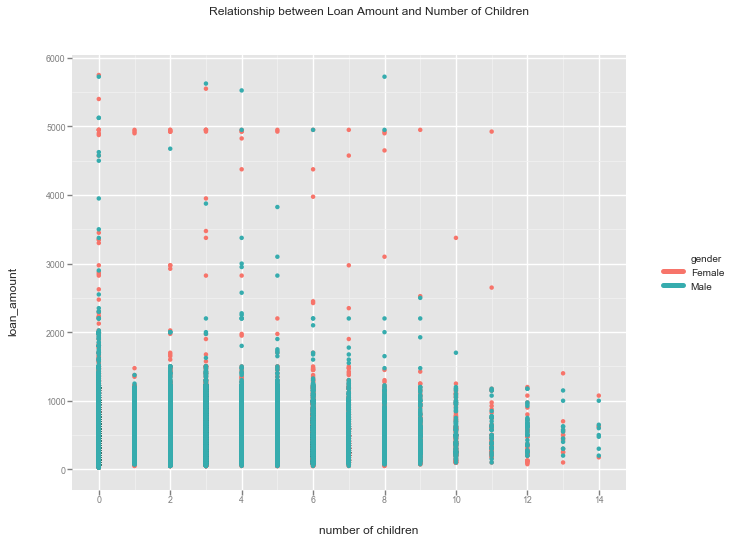

<ggplot: (-9223372036533381835)>

In [57]:
ggplot(df[(df['borrower_count'] == 1)], aes(x = 'children_int', y = 'loan_amount', color="gender")) + geom_point() + \
ggtitle("Relationship between Loan Amount and Number of Children") + xlab("number of children") + ylab("loan_amount")

Surprisingly, in the chart above it appears that women may be requesting more than men? This is really surprising, since all our analysis of gender so far has communicated that women on average request less. Let's see what is going on by returning to our binary childrens boxplot from earlier.

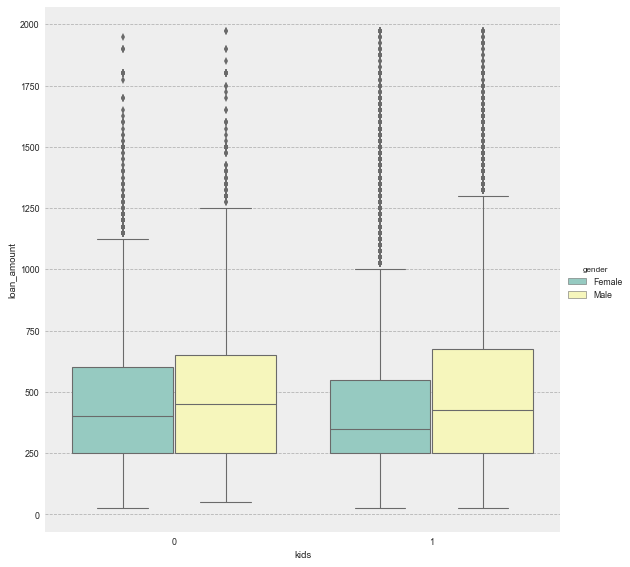

In [58]:
plt.figure(figsize=(8, 20))

sns.set_context("paper", font_scale=1.1, rc={"lines.linewidth": 1.1})

g=sns.factorplot(x="kids", y="loan_amount", hue="gender", palette="Set3", data=df[df['loan_amount']<2000], kind="box",orient="v", size=8, aspect=1)

It turns out this is not the case, men with children are still requesting more than women with children. This is why using a tool like boxplots is so important. It is a powerful way to quantify the distribution we percieve.

Let's also plot is using our more granular number of children data. This again reinforeces that women are systematically asking for less than men.

We can also note that although we percieved a negative relationship between number of children and loan amount requested in our initial scatter plot, it appears that at least the median loan amount requested goes up as the number of children go up. 

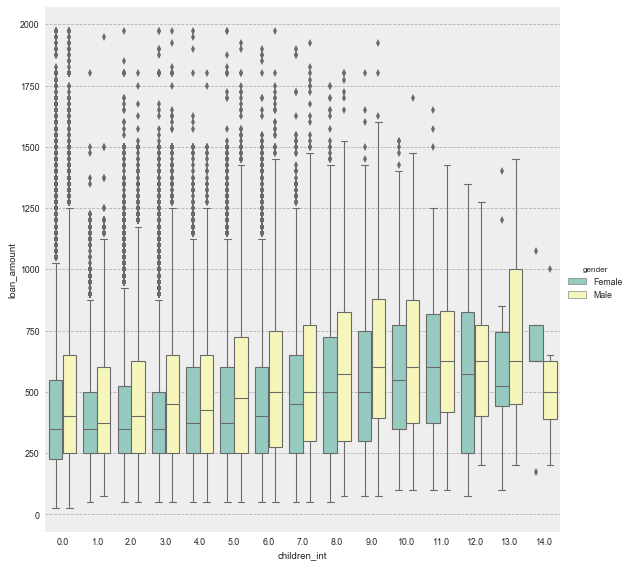

In [59]:
plt.figure(figsize=(8, 20))

sns.set_context("paper", font_scale=1.1, rc={"lines.linewidth": 1.1})

g=sns.factorplot(x="children_int", y="loan_amount", hue="gender", palette="Set3", data=df[df['loan_amount']<2000], kind="box",orient="v", size=8, aspect=1)

The number of children feature is very promising, we will definately be including it in our model!

## Age

Now let's turn to age. Below, we plot age against loan amount to get a sense of the strength of the relationship.

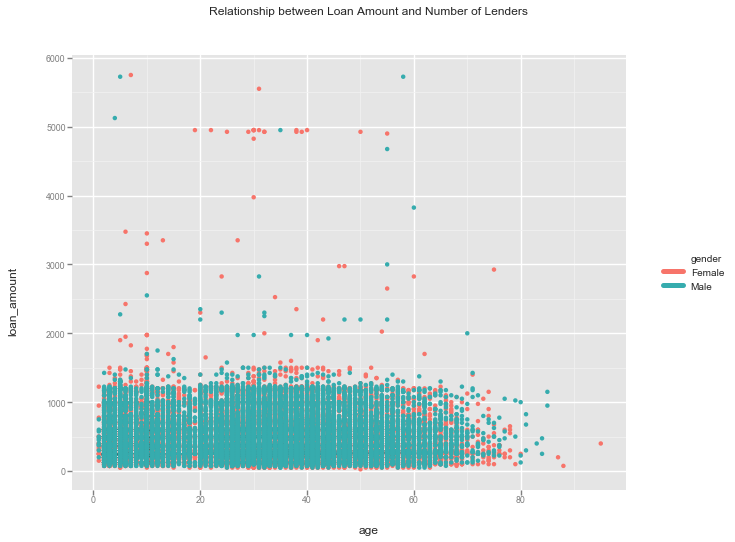

<ggplot: (-9223372036507587261)>

In [60]:
ggplot(df[(df['borrower_count'] == 1)], aes(x = 'age_int', y = 'loan_amount', color="gender")) + geom_point() + \
ggtitle("Relationship between Loan Amount and Number of Lenders") + xlab("age") + ylab("loan_amount")

From the chart above, we can see that while we have learnt something about the age distribution it is unfortunately not particularly powerful at predicting loan amount. We decide to try one more thing and bucket age to see if it strengthens the relationship.

In [61]:
mybins =range(0, 90, 10)
df['age_bucket'] = pd.cut(df['age_int'], bins=mybins)
df['age_bucket'].value_counts()

(30, 40]    12422
(0, 10]     12330
(20, 30]     9529
(40, 50]     8487
(10, 20]     6262
(50, 60]     4766
(60, 70]     1587
(70, 80]      234
Name: age_bucket, dtype: int64

Strange -- looks like there are a lot of 10 year olds borrowers! This doesn't make sense, so let's take a look at the data where age_int < 10 to investigate. 

In [62]:
df[df['age_int']< 2].head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,activity,basket_amount,bonus_credit_eligibility,borrowers,currency_exchange_loss_amount,description.languages,description.texts.en,description.texts.es,description.texts.fr,description.texts.ru,funded_amount,funded_date,id,image.id,image.template_id,journal_totals.bulkEntries,journal_totals.entries,lender_count,loan_amount,location.country,location.country_code,location.geo.level,location.geo.pairs,location.geo.type,location.town,name,partner_id,payments,planned_expiration_date,posted_date,sector,status,tags,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,terms.local_payments,terms.loss_liability.currency_exchange,terms.loss_liability.currency_exchange_coverage_rate,terms.loss_liability.nonpayment,terms.repayment_interval,terms.repayment_term,terms.scheduled_payments,themes,translator.byline,translator.image,...,partner_default_rate_note,partner_delinquency_rate,partner_delinquency_rate_note,partner_image.id,partner_image.template_id,partner_loans_at_risk_rate,partner_loans_posted,partner_name,partner_portfolio_yield,partner_portfolio_yield_note,partner_profitability,partner_rating,partner_social_performance_strengths,partner_start_date,partner_status,partner_total_amount_raised,partner_url,posted_datetime,planned_expiration_datetime,funded_datetime,dispursal_datetime,dispersal_date,posted_year,number_of_loans,gender,num_tags,tag_#Woman Owned Biz,tag_#Parent,tag_user_favorite,tag_#Repeat Borrower,tag_#Schooling,tag_volunteer_pick,tag_#Vegan,tag_volunteer_like,tag_#Animals,tag_#Eco-friendly,tag_#Technology,widowed,kids,elderly,repeat_borrower,married,age,children_1,children_2,children_int_1,children_int_2,age_int,children_int,age_bucket
114,114,114,1710,Fruits & Vegetables,0.0,False,"[{'first_name': 'Joseph', 'last_name': '', 'ge...",NaN,['en'],Joseph is a 30-year-old man and is happily mar...,NaN,NaN,NaN,0,NaN,1275366,2494142,1,0,0,0,450,Kenya,KE,town,0.516667 36.866667,point,Narok,Joseph,386.0,[],2017-05-16,2017-04-16,Food,fundraising,"[{'name': '#Vegan'}, {'name': '#Parent'}, {'na...",45000.0,KES,2017-03-08T08:00:00Z,450,"[{'due_date': '2017-04-12T07:00:00Z', 'amount'...",shared,0.1,lender,Monthly,14,"[{'due_date': '2017-07-01T07:00:00Z', 'amount'...",NaN,Christine Haiss,1251749.0,...,NaN,7.017031,NaN,1592272,1,21.165398,1948,Kenya ECLOF,40.3,NaN,2.54,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2014-05-29T13:30:02Z,active,863375,http://www.eclof-kenya.org/,2017-04-16 13:50:07,2017-05-16 13:50:07,NaN,2017-03-08 08:00:00,2017-03-08,2017,1,Male,2,0,1,0,1,0,0,1,0,0,0,0,0,1,0,1,1,1 years,two children,,2.0,NaN,1.0,2.0,"(0, 10]"
618,618,618,7903,Motorcycle Transport,NaN,False,"[{'first_name': 'Christopher', 'last_name': ''...",NaN,['en'],Christopher is a happily married man and they ...,NaN,NaN,NaN,400,2017-02-07,1221313,2418226,1,0,0,5,400,Kenya,KE,town,0.516667 35.283333,point,Eldoret,Christopher,386.0,[],2017-02-16,2017-01-17,Transportation,funded,"[{'name': 'user_favorite'}, {'name': '#First L...",40000.0,KES,2016-12-28T08:00:00Z,400,[],shared,0.1,lender,NaN,11,[],NaN,Tim Gibson,1632475.0,...,NaN,7.017031,NaN,1592272,1,21.165398,1948,Kenya ECLOF,40.3,NaN,2.54,2.0,"[{'id': 3, 'name': 'Client Voice', 'descriptio...",2014-05-29T13:30:02Z,active,863375,http://www.eclof-kenya.org/,2017-01-17 11:30:05,2017-02-16 11:30:05,2017-02-07 11:30:49,2016-12-28 08:00:00,2016-12-28,2017,1,Male,3,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1 years,,4 children,NaN,4.0,1.0,4.0,"(0, 10]"
660,660,660,8702,Animal Sales,NaN,False,"[{'first_name': 'Ntalamer', 'last_name': '', '...",NaN,['en'],"This is Ntalamer, who is married with two chil...",NaN,NaN,NaN,300,NaN,1215911,2409165,1,0,0,12,500,Kenya,KE,town,0.516667 36.866667,point,Narok,Ntalamer,386.0,[],2017-02-05,2017-01-06,Agriculture,expired,"[{'name': '#Animals'}, {'name': '#Parent'}]",50000.0,KES,2016-12-06T08:00:00Z,500,[],shared,0.1,lender,NaN,10,[],NaN,Katie Bradshaw,1722852.0,...,NaN,7.017031,NaN,1592272,1,21.165398

The data tells us that many people are not reporting their own age, but in fact are telling us about their young children. This reveals a big data integrity problem - the feature age_int is not what we thought it was. This raises the question of how many people reported their own age in the first place. 

One way to address this is to conservatively only look at observations where the age is more than 20. We do this below by starting at bins at 20.

In [63]:
mybins =range(20, 90, 10)
df['age_bucket'] = pd.cut(df['age_int'], bins=mybins)
##df['age_bucket'].value_counts()

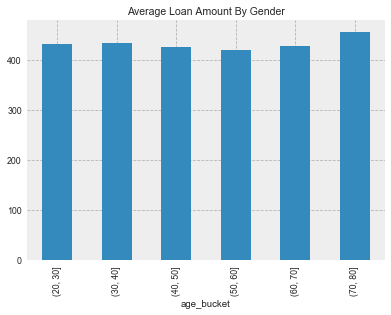

In [64]:
df[df['borrower_count'] == 1].groupby('age_bucket')['loan_amount'].mean().plot(kind="bar", title="Average Loan Amount By Gender")

Unfortunately, it did not improve the relationship. While 70-80 year olds appear to be requesting larger loans on avg it is very similar amounts for all other ages. But don't despair!

Again, meeting dead ends in feature engineering is a perfectly normal part of developing a model. We included all these weaker feature explorations so you can understand that even experienced data scientists try a lot of things that are not successful. 

The best way to build a successful model is to iterate quickly and not get stuck when a feature doesn't work out.

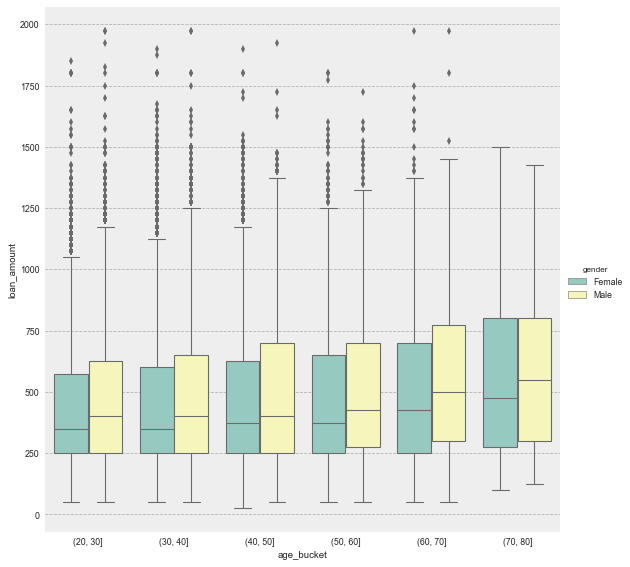

In [65]:
plt.figure(figsize=(8, 20))

sns.set_context("paper", font_scale=1.1, rc={"lines.linewidth": 1.1})

g=sns.factorplot(x="age_bucket", y="loan_amount", hue="gender", palette="Set3", data=df[df['loan_amount']<2000], kind="box",orient="v", size=8, aspect=1)

The last thing we do is fill in empty age with the mean.

In [75]:
df['age_int']=df['age_int'].fillna(df['age_int'].mean())

## Repeat Borrowers

## Location

## IMPORTANT, this is a fairly computationally piece of code. You may have to re-run the location match because the api sometimes break. Please save your dataframe as soon as it is done so you do not have to run it again.

Location is probably very predictive of loan amount because of differences in the cost of living and the type of sector concentrated in different regions. However, our current data is really messy! There is an issue with of geo-coordinates field where most coordinates are from a single location. Instead, we have to rely on location.town but this appears to be entered by hand and there are many spelling mistakes, variations of the same entry that prevent us from aggregating this data in a useful way. In order to use location, we somehow need to pull the province or county associated with each town. To do this we turn to the Google Geocode API. 

The api is very sensitive to how clean (standardized) the input is. Because our location field appears to be a non standardized field (it is the result of data written by hand), we have a lot of cleaning to do before we can call the api. However, even after this cleaning the api call tends to break frequently so we set up a recursive function, which means if there is an exception because of the quality of text or because the internet is weak, it calls the function again.

In [76]:
df['location']=df['location.town'].astype(str).map(lambda x: re.sub(r'[^a-zA-Z0-9 ]',r'',x).lower().rstrip().lstrip())
df['location']=df['location'].map(lambda x: re.sub(r'kenya', r'', x))
df['location']=df['location'].map(lambda x: re.sub(r' +', r' ', x))

df['location']=df['location'] + ' ' + 'kenya'

unique_location = df['location'].unique()
unique_location.sort()
len(unique_location)

1204

In [ ]:
lookup={}
geolocator = Nominatim()

def location_match(unique_location, lookup):
    #creates empty dictionary
    y=0
    print(len(unique_location))
    for x in unique_location:
        if x in lookup.keys():
            print ('already added, pct complete %d' % (100.00*y/len(unique_location)))
        else:
            print ('adding %s, %d out of %d, pct complete %d' % (x, y, len(unique_location), 100.00*y/len(unique_location)))
            try:
                lookup[x]=geolocator.geocode(x, timeout=10)
            except GeocoderTimedOut:
                return location_match(unique_location, lookup)
                return lookup
        y=y+1
            
    return lookup

In [81]:
location = location_match(unique_location, lookup)



1204
already added, pct complete 0
already added, pct complete 0
already added, pct complete 0
already added, pct complete 0
already added, pct complete 0
already added, pct complete 0
already added, pct complete 0
already added, pct complete 0
already added, pct complete 0
already added, pct complete 0
already added, pct complete 0
already added, pct complete 0
already added, pct complete 0
already added, pct complete 1
already added, pct complete 1
already added, pct complete 1
already added, pct complete 1
already added, pct complete 1
already added, pct complete 1
already added, pct complete 1
already added, pct complete 1
already added, pct complete 1
already added, pct complete 1
already added, pct complete 1
already added, pct complete 1
already added, pct complete 2
already added, pct complete 2
already added, pct complete 2
already added, pct complete 2
already added, pct complete 2
already added, pct complete 2
already added, pct complete 2
already added, pct complete 2
alrea

In [82]:
df.location = location

ValueError: Length of values does not match length of index

In [83]:
df['location_detail'] = df['location'].map(location)

df['location_str']=df['location_detail'].astype(str).map(lambda x: re.sub(r'Kenya',r'',x).lower().rstrip().lstrip())

In [84]:
lookup_tags=pd.read_csv(data_path+'/province_counties_KE.csv', low_memory=False)

In [85]:
lookup_tags['county'].unique()

array(['mombasa', 'kwale', 'kilifi', 'tana river', 'lamu', 'taita',
       'garissa', 'wajir', 'mandera', 'marsabit', 'isiolo', 'meru',
       'tharaka', 'embu', 'kitui', 'machakos', 'makueni', 'nyandarua',
       'nyeri', 'kirinyaga', 'muranga', 'kiambu', 'turkana', 'pokot',
       'samburu', 'trans nzoia', 'uasin', 'elgeyo', 'nandi', 'baringo',
       'laikipia', 'nakuru', 'narok', 'kajiado', 'kericho', 'bomet',
       'kakamega', 'vihiga', 'bungoma', 'busia', 'siaya', 'kisumu', 'homa',
       'migori', 'kisii', 'nyamira', 'nairobi'], dtype=object)

In [87]:
# define a function that performs a loop that parses out all words, 
#  finds age and number of children match and creates a list that is return at the end of the function

def text_search(tag):
    #creates empty lists that are then added to in loop
    number=[]
    flag = tag.astype(str)
    match=flag.tolist()
    print(match)
    match = re.compile(r'\b(?:%s)\b' % '|'.join(match))
    for descr in df['location_str']:
        try:
            if isinstance(descr, str):
                    if re.findall(match, descr):
                        match_0=re.findall(match,  descr)
                        match_1=re.findall(match,  descr)[:1]
                        word_1=" ".join(match_1)
                        number.append(word_1)
                    else:
                        number.append('')
        except:
            print('error')
            
    return(number)

In [89]:
number= text_search(lookup_tags['county'])
df['county']=pd.DataFrame(number)

['mombasa', 'kwale', 'kilifi', 'tana river', 'lamu', 'taita', 'garissa', 'wajir', 'mandera', 'marsabit', 'isiolo', 'meru', 'tharaka', 'embu', 'kitui', 'machakos', 'makueni', 'nyandarua', 'nyeri', 'kirinyaga', 'muranga', 'kiambu', 'turkana', 'pokot', 'samburu', 'trans nzoia', 'uasin', 'elgeyo', 'nandi', 'baringo', 'laikipia', 'nakuru', 'narok', 'kajiado', 'kericho', 'bomet', 'kakamega', 'vihiga', 'bungoma', 'busia', 'siaya', 'kisumu', 'homa', 'migori', 'kisii', 'nyamira', 'nairobi']


In [90]:
mydict = dict(zip(lookup_tags.county, lookup_tags.province))
df['province']= df['county'].map(mydict)

mydict = dict(zip(lookup_tags.county, lookup_tags.capital))
df['province_capital']= df['county'].map(mydict)

In [91]:
df['province']=df['province'].fillna('Missing')
df['county']=df['county'].fillna('Missing')

In [92]:
df.to_csv(data_path+'df_module_2_w_outliers.csv')

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

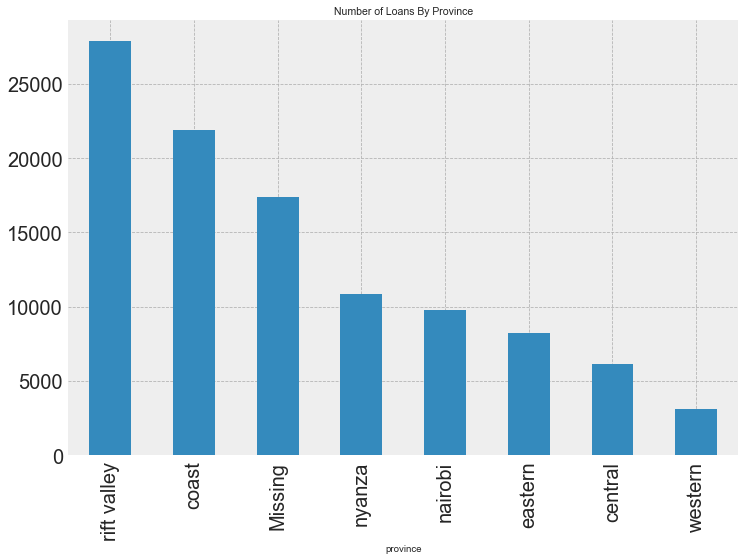

In [93]:
df[(df['borrower_count'] == 1)].groupby('province')['loan_amount'].count().nlargest(10).plot(kind="bar",  fontsize=20,figsize=(12,8),title='Number of Loans By Province')
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

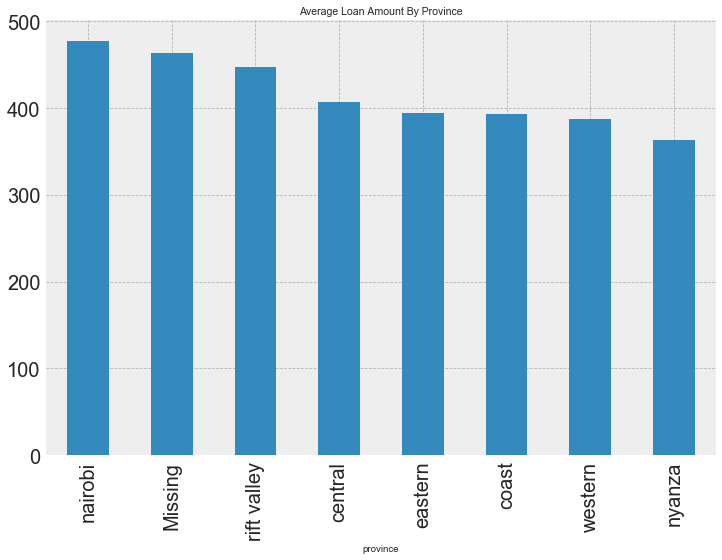

In [94]:
df[(df['borrower_count'] == 1)].groupby('province')['loan_amount'].mean().nlargest(10).plot(kind="bar",  fontsize=20,figsize=(12,8),title='Average Loan Amount By Province')
plt.xticks(rotation=90)

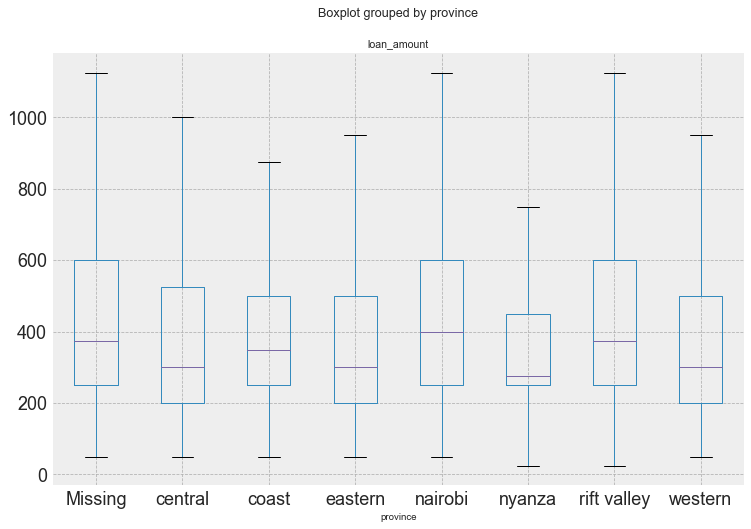

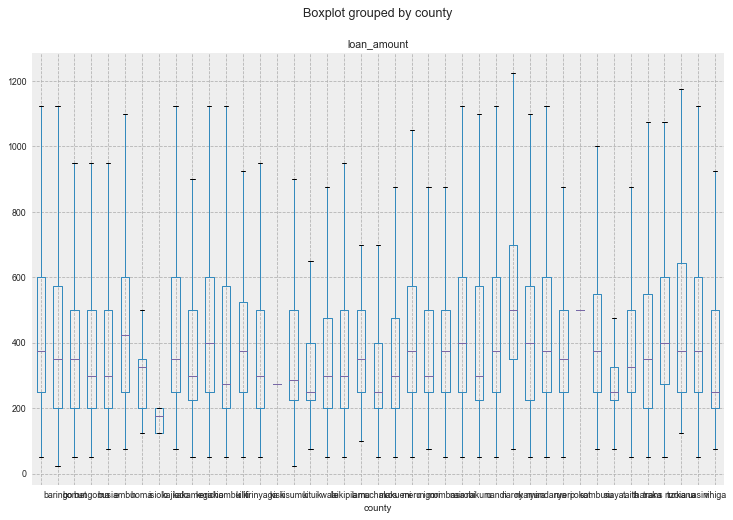

In [95]:
df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='province', showfliers=False, fontsize=18, figsize=(12,8))

df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='county', showfliers=False, figsize=(12,8))

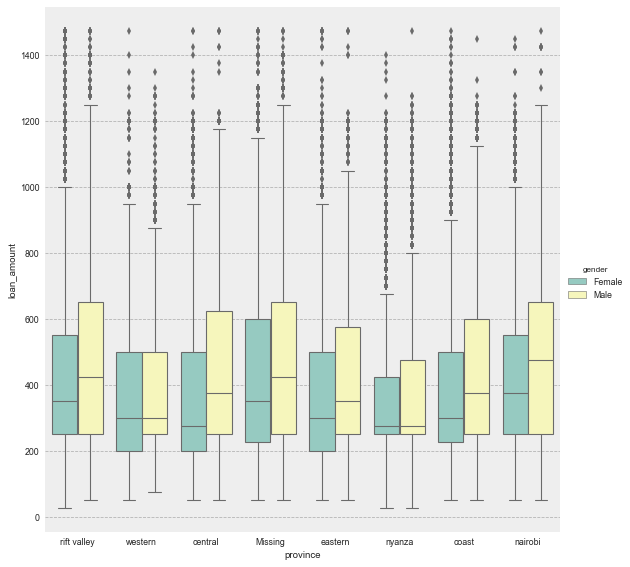

In [96]:
plt.figure(figsize=(8, 20))

sns.set_context("paper", font_scale=1.1, rc={"lines.linewidth": 1.1})

g=sns.factorplot(x="province", y="loan_amount", hue="gender", palette="Set3", data=df[(df['borrower_count'] == 1)&(df['loan_amount']<1500)], kind="box",orient="v", size=8, aspect=1)

## Step 2: Loan features

Next we create features related to the conditions surrounding each loan posting that we believe may drive loan amount.

## Loan Description

## Sector and Activity

We know from our exploratory analysis in the last lesson that sector and activity are both important drivers of loan amount. We will be including both of these in our linear regression.

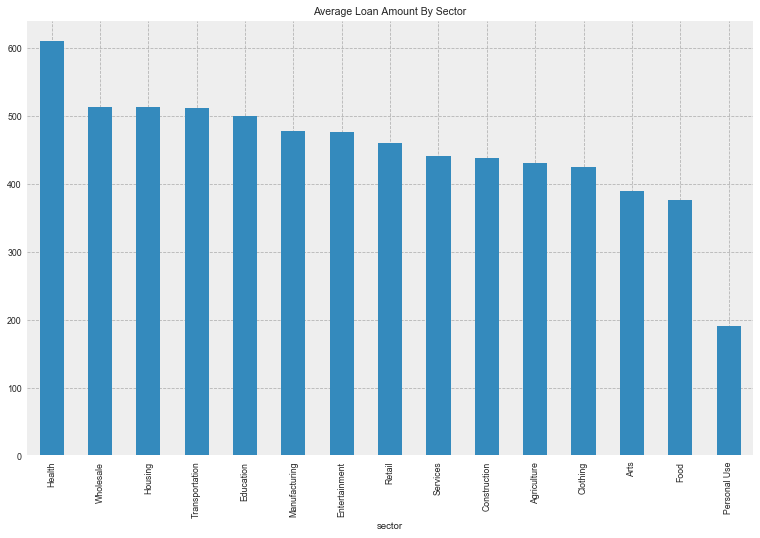

In [97]:
df[df['borrower_count'] == 1].groupby('sector')['loan_amount'].mean().nlargest(20).plot(kind="bar", title="Average Loan Amount By Sector", figsize=(13, 8))

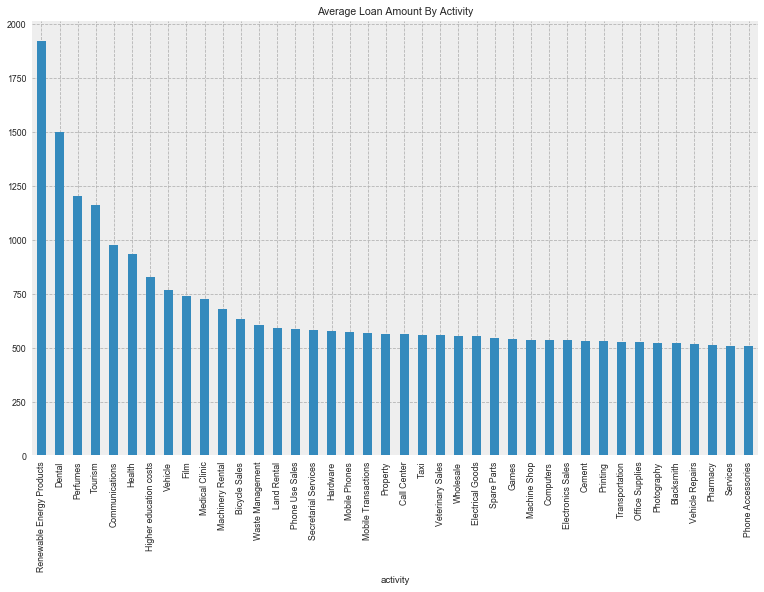

In [98]:
df[df['borrower_count'] == 1].groupby('activity')['loan_amount'].mean().nlargest(40).plot(kind="bar", title="Average Loan Amount By Activity", figsize=(13, 8))

## Aggregate Features

## Time features

In order to leverage time features, we first need to make sure that the data is in Python's datetime format. Once all relevant features are converted to this format, we can perform operations on them.

As we saw in Module 1, we already ensured our date features are converted to datetime format using the `to_datetime` function. However, in reading in our "df" csv file, Python forgot the Pandas format we assigned. Therefore we convert our created variables to datetime format again. We then create a day feature from each of the datetime differences we calculate.

In [99]:
## Ensuring datetime format
df['planned_expiration_datetime'] = pd.to_datetime(df['planned_expiration_datetime'])
df['posted_datetime'] = pd.to_datetime(df['posted_datetime'])

## Time to fund is the funded date minus the posted date
df['time_to_fund'] =pd.to_datetime(df['funded_datetime']) - pd.to_datetime(df['posted_datetime'])
df['days_to_fund'] = df.time_to_fund.dt.days

## Time to expiration is the expiration date minus the Posted Date
df['time_to_expire_datetime'] =df['planned_expiration_datetime'] - df['posted_datetime']
df['days_to_expire'] = df.time_to_expire_datetime.dt.days
df['posted_year']=df['posted_datetime'].dt.year
df['posted_month']=df['posted_datetime'].dt.month

## Time to dispursement is the Disbursed date minus the Posted Date
df['time_to_dispersal'] =pd.to_datetime(df['dispursal_datetime']) - pd.to_datetime(df['posted_datetime'])
df['days_to_dispersal'] = df.time_to_dispersal.dt.days

# Convert string into numeric for posted_date
df["posted_date_unix"] = pd.to_datetime(df['posted_date']).apply(lambda x: time.mktime(x.timetuple()) if not pd.isnull(x) else 0)

Do you remember the first exploratory notebook we plotted avg loan amount by year and found it fairly stable?

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

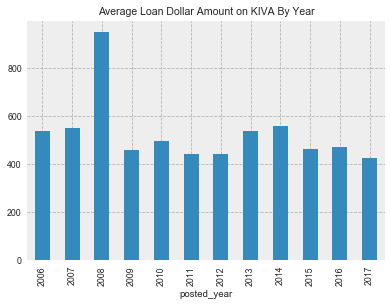

In [100]:
df.groupby('posted_year')['loan_amount'].mean().plot(kind="bar", title='Average Loan Dollar Amount on KIVA By Year')
plt.xticks(rotation=90)

Now, since we are trying to understand what drives loan amount, we restrict (as we have done in all charts so far) our dataset to loans with a single borrower. In the chart below, we plot the average loan amount by year. This restriction has a big impact on the relationshop, we see that the average loan amount goes down year over year.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

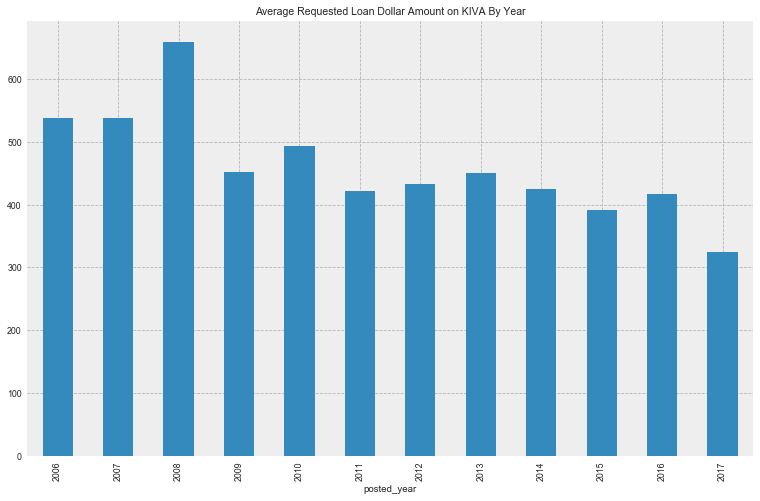

In [101]:
df[df['borrower_count'] == 1].groupby('posted_year')['loan_amount'].mean().plot(kind="bar", figsize=(13, 8),title='Average Requested Loan Dollar Amount on KIVA By Year')
plt.xticks(rotation=90)

Why does loan amount requested go down? One possibility is that partners learn from experience what does and does not get funded. Remember our exploratory analsysis showed expired loans tended to be much larger on average. Perhaps lenders figured out their odds of success go up if they request lower amounts.

### Do loans amounts spike at certain point during the year?

It might be interesting to also look at loan size by month. It is very possible that end-of-year celebrations or the beginning of the school year in January put a strain on household budgets and result in higher loan amount requests.

We can see below that the loan amount is on average higher in **November, December and February**. This seems to strengthen our hypothesis that loan amount is driven somewhat by seasonal preassures.

As always, we follow-up with a box plot. This helps us understand the variance in loan amount between months. The results confirm our understanding that the distribution varies by month, we will include this feature.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

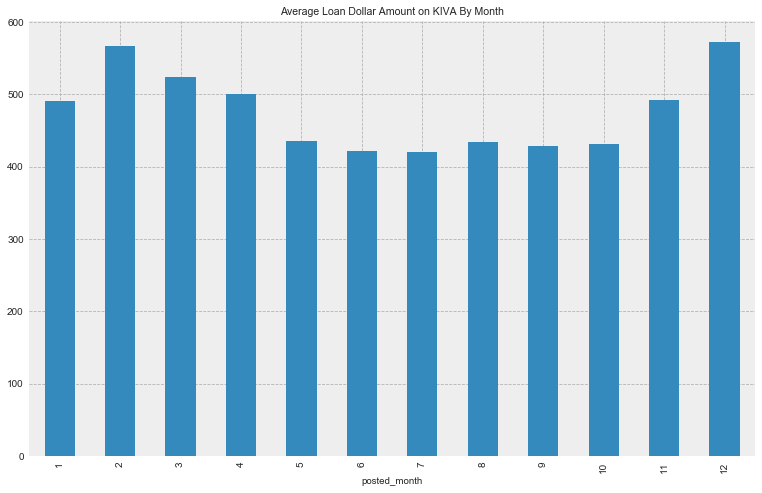

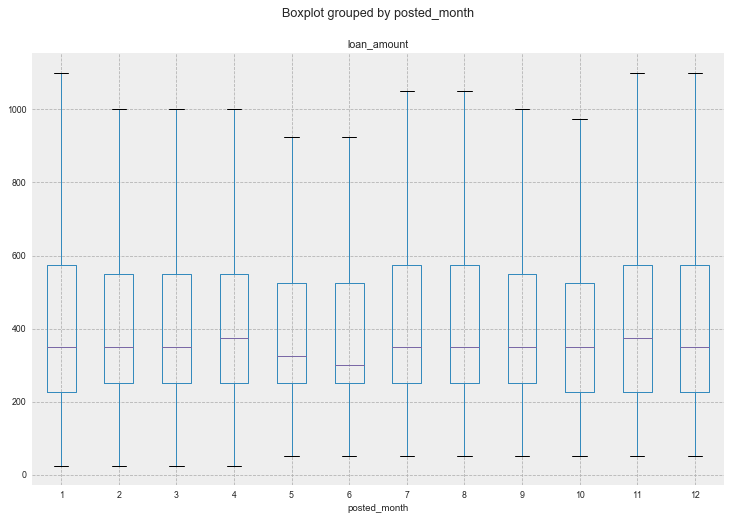

In [102]:
df.groupby('posted_month')['loan_amount'].mean().plot(kind="bar", figsize=(13, 8), fontsize=10,title='Average Loan Dollar Amount on KIVA By Month')
plt.xticks(rotation=90)

df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='posted_month', showfliers=False, figsize=(12,8))

## Days to fund

There are some erroneous values in the days_to_fund feature which must the results of an incorrect posted or funded date. Therefore lets remove the data point where days_to_fund are negative. Luckily this only corresponds to 25 records. 

In [103]:
# There are some erroneous values in the days_to_fund features so lets remove 
df['days_to_fund'].max()
df['days_to_fund'].min()
df[df['days_to_fund'] < 0]['days_to_fund'].value_counts()
df = df[df['days_to_fund']>=0]
#check that has worked
df['days_to_fund'].min()

62.0

-442.0

-442.0    19
-411.0     5
-1.0       1
Name: days_to_fund, dtype: int64

0.0

The appears to be a weak positive relationship between days to fund and the loan amount. We should keep this feature in mind.

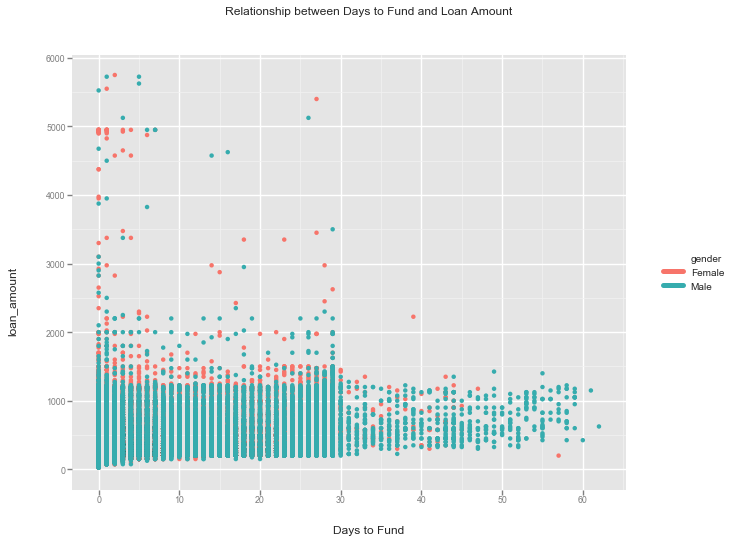

<ggplot: (322133277)>

In [104]:
ggplot(df[(df['borrower_count'] == 1)], aes(x = 'days_to_fund', y = 'loan_amount', color="gender")) + geom_point() + \
ggtitle("Relationship between Days to Fund and Loan Amount") + xlab("Days to Fund") + ylab("loan_amount")

## Step 3: Partner Features

Recall from our exploratory analysis that KIVA relies heavily on it's partners to dispense loans in Kenya. In fact, only a negligable amount of loans are not associated with a partner. It is clearly important to take into account partner dynamics as we continue with our feature engineering.

## Number of countries partners are in

We can find the number of partners by doing a lookup of the number of times name appears in the partner_countries field. this appears once for each country.

In [105]:
df['num_partner_countries'] = df['partner_countries'].apply(lambda x: x.count('name'))

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [106]:
df['num_partner_countries'].value_counts()

1    102305
2      9985
4       273
5         6
Name: num_partner_countries, dtype: int64

In [107]:
df['more_one_partner_country'] = np.where(df['num_partner_countries']==1, 0, 1)
df['us_partner'] = np.where(df['partner_countries'].str.contains("US", na=0)==True, 1, 0)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [108]:
df['more_one_partner_country'].value_counts()
df['us_partner'].value_counts()

0    102305
1     10264
Name: more_one_partner_country, dtype: int64

0    112340
1       229
Name: us_partner, dtype: int64

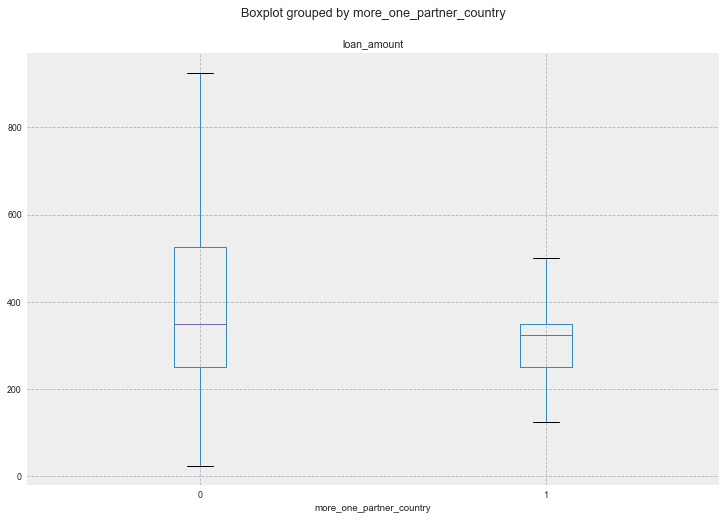

In [109]:
df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='more_one_partner_country', showfliers=False, figsize=(12,8))

## Partner Profitability and Financial Stability

How do partners affect loan amount? Does a partner's profitability have anything to do with the loan amount issued. Firstly, we evaluate a potential data issue where some partners have profitability below 0.

In [110]:
df[df['partner_profitability']<0].head(2)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,activity,basket_amount,bonus_credit_eligibility,borrowers,currency_exchange_loss_amount,description.languages,description.texts.en,description.texts.es,description.texts.fr,description.texts.ru,funded_amount,funded_date,id,image.id,image.template_id,journal_totals.bulkEntries,journal_totals.entries,lender_count,loan_amount,location.country,location.country_code,location.geo.level,location.geo.pairs,location.geo.type,location.town,name,partner_id,payments,planned_expiration_date,posted_date,sector,status,tags,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,terms.local_payments,terms.loss_liability.currency_exchange,terms.loss_liability.currency_exchange_coverage_rate,terms.loss_liability.nonpayment,terms.repayment_interval,terms.repayment_term,terms.scheduled_payments,themes,translator.byline,translator.image,...,posted_datetime,planned_expiration_datetime,funded_datetime,dispursal_datetime,dispersal_date,posted_year,number_of_loans,gender,num_tags,tag_#Woman Owned Biz,tag_#Parent,tag_user_favorite,tag_#Repeat Borrower,tag_#Schooling,tag_volunteer_pick,tag_#Vegan,tag_volunteer_like,tag_#Animals,tag_#Eco-friendly,tag_#Technology,widowed,kids,elderly,repeat_borrower,married,age,children_1,children_2,children_int_1,children_int_2,age_int,children_int,age_bucket,location,location_detail,location_str,county,province,province_capital,time_to_fund,days_to_fund,time_to_expire_datetime,days_to_expire,posted_month,time_to_dispersal,days_to_dispersal,posted_date_unix,num_partner_countries,more_one_partner_country,us_partner
2396,2396,2396,16,Primary/secondary school costs,NaN,False,"[{'first_name': 'Sally ', 'last_name': '', 'ge...",NaN,['en'],"Sally is an ambitious woman from Bomet, a maiz...",NaN,NaN,NaN,150,2017-05-09,1291449,2515878,1,0,0,6,150,Kenya,KE,town,1 38,point,Bomet,Sally,156.0,[],2017-06-07,2017-05-08,Education,funded,"[{'name': '#Parent'}, {'name': '#Schooling'}]",15000.0,KES,2017-05-28T07:00:00Z,150,[],shared,0.1,lender,NaN,13,[],NaN,NaN,NaN,...,2017-05-08 22:30:06,2017-06-07 22:30:06,2017-05-09 00:37:46,2017-05-28 07:00:00,2017-05-28,2017,1,Female,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,,,,NaN,NaN,29.560149,0.0,NaN,bomet kenya,"(Bomet, Kenya, (-0.71845775, 35.2391248061497))","bomet,",bomet,rift valley,bomet,02:07:40,0.0,30 days,30.0,5,19 days 08:29:54,19,1.494191e+09,1,0,0
2401,2401,2401,26,Primary/secondary school costs,NaN,False,"[{'first_name': 'Sally', 'last_name': '', 'gen...",NaN,['en'],"Sally is an ambitious woman from a lush, maize...",NaN,NaN,NaN,150,2017-05-08,1291369,2515770,1,0,0,6,150,Kenya,KE,town,-0.583333 35.183333,point,litein,Sally,156.0,[],2017-06-07,2017-05-08,Education,funded,"[{'name': '#Parent'}, {'name': '#Schooling'}]",15000.0,KES,2017-04-28T07:00:00Z,150,[],shared,0.1,lender,NaN,14,[],NaN,NaN,NaN,...,2017-05-08 21:00:06,2017-06-07 21:00:06,2017-05-08 22:08:34,2017-04-28 07:00:00,2017-04-28,2017,1,Female,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,,,,NaN,NaN,29.560149,0.0,NaN,litein kenya,"(Litein, Kericho, Kenya, (-0.5833, 35.1833))","litein, kericho,",kericho,rift valley,kericho,01:08:28,0.0,30 days,30.0,5,-11 days +09:59:54,-11,1.494191e+09,1,0,0


This is strange. We are not sure why there would be partners with profitability below 0. We plan to ask the KIVA team but until we get an answer we will focus on partner delinquency.

Below we see that partner deliquency appears to have postive relationship with loan amount. This suggests that some partners may be requesting too high a loan amount, and are unable to pay it back. Instead, let's look at some other features that may drive loan amount. 

Two other patner features that are interesting are partner delinquency rate and the number of partner loans posted.

Why do you think we are interested in these features? What is a conceivable hypothesis?

## Delinquency rate

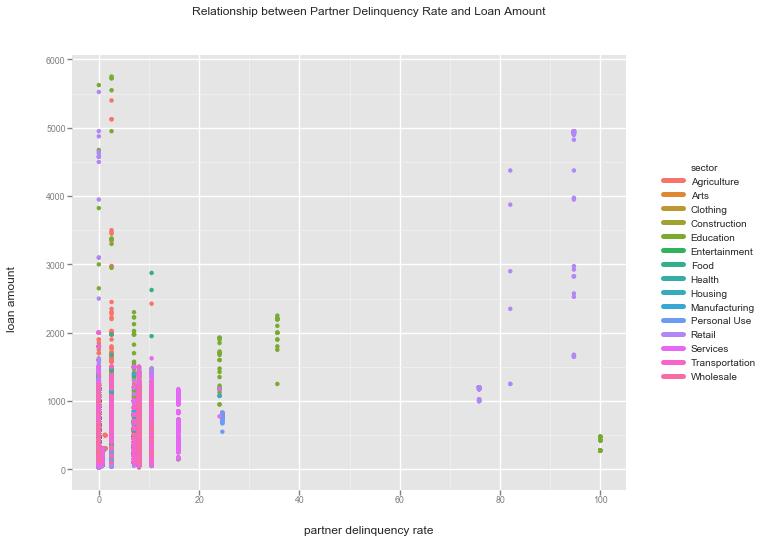

<ggplot: (320913093)>

In [111]:
ggplot(df[(df['borrower_count'] == 1)], aes(x = 'partner_delinquency_rate', y = 'loan_amount', color="sector")) + geom_point() + \
ggtitle("Relationship between Partner Delinquency Rate and Loan Amount") + xlab("partner delinquency rate") + ylab("loan amount")

We can see from the chart above that there does in fact appear to be a positive relationship between partner delinquency rate and loan amount. Additionally, it appear certain sectors (like construction and retail) have a higher risk of delinquency. Good to know! We will be including this feature in our model.

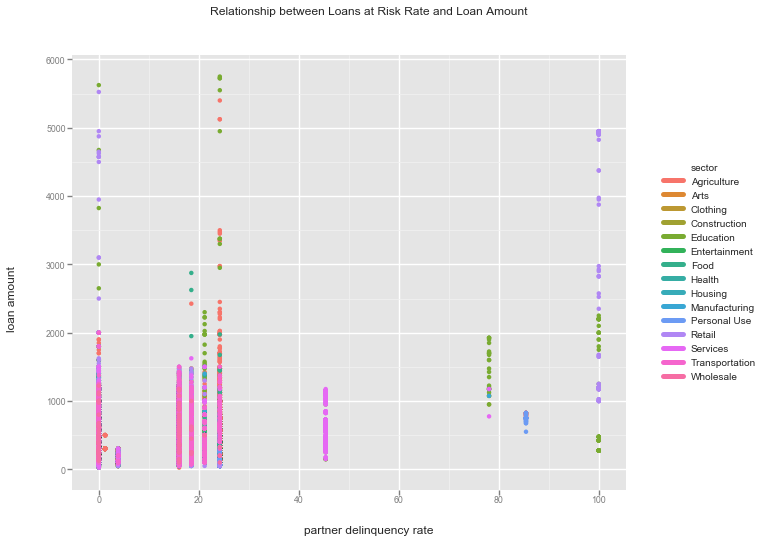

<ggplot: (322250539)>

In [112]:
ggplot(df[(df['borrower_count'] == 1)], aes(x = 'partner_loans_at_risk_rate', y = 'loan_amount', color="sector")) + geom_point() + \
ggtitle("Relationship between Loans at Risk Rate and Loan Amount") + xlab("partner delinquency rate") + ylab("loan amount")

## Number of Loans Posted

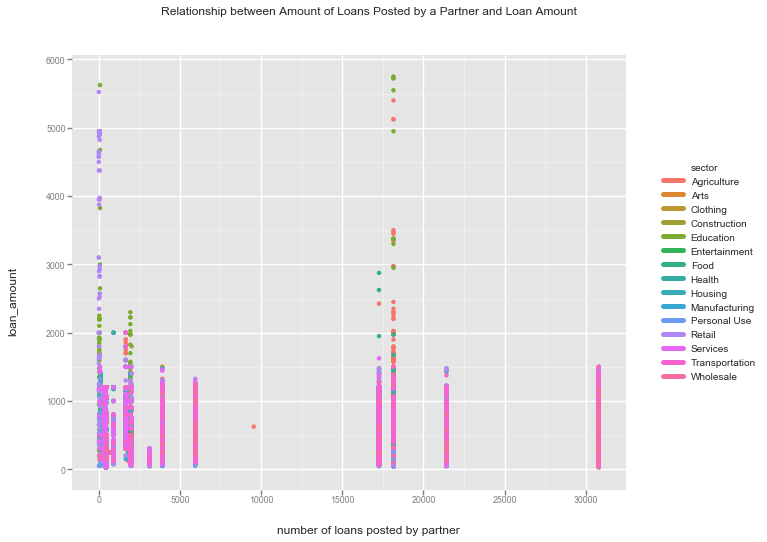

<ggplot: (320924150)>

In [113]:
ggplot(df[(df['borrower_count'] == 1)], aes(x = 'partner_loans_posted', y = 'loan_amount', color="sector")) + geom_point() + \
ggtitle("Relationship between Amount of Loans Posted by a Partner and Loan Amount") + xlab("number of loans posted by partner") + ylab("loan_amount")

The feature does seem initally promising, albeit weak. It suggests that as partner loans posted goes up the loan amont goes down. It would be interesting to try this in our model, but we should be aware of a potential issue with this feature.


The issue, as we can see in the chart above is that partner_loans_posted ends up serving as a unique identifier for a partner_id. We must make sure not to include both partner_loans_posted and partner_id because they are probably highly correlated. Ask in slack if you don't understand why this is true.

## Loan Concentration

(array([], dtype=float64), <a list of 0 Text xticklabel objects>)

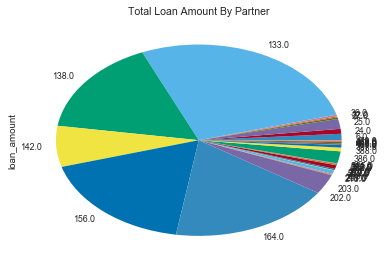

In [114]:
#change color plot

df[(df['borrower_count'] == 1)].groupby('partner_id')['loan_amount'].sum().plot(kind="pie", title='Total Loan Amount By Partner')
plt.xticks(rotation=90)

In [115]:
df[(df['borrower_count'] == 1)].groupby('partner_name')['loan_amount'].sum().nlargest(5)

partner_name
VisionFund Kenya           11352025
Yehu Microfinance Trust     7638050
Juhudi Kilimo               7498350
SMEP Microfinance Bank      6734050
Faulu Kenya                 2892775
Name: loan_amount, dtype: int64

In [116]:
# two functions below output new field where all partners not in top 5 are bucketed together.
# We have to do this in two different functions because partner_id and partner_name are different types. You can
# see this using our dtype code below.

df['partner_id'].dtype
df['partner_name'].dtype

def top_partners_id(x):
   partners_id = [] 
   for p in x:
        if p in [138.0, 133.0, 156.0, 164.0,142.0]:
           partners_id.append(p)
        else:
           partners_id.append(1.0)
   return partners_id

def top_partners(x):
   partners = []
   for p in x:
       if p in ['VisionFund Kenya', 'Juhudi Kilimo', 'Yehu Microfinance Trust', 'Faulu Kenya','SMEP Microfinance Bank']:
           partners.append(p)
       else:
           partners.append('other')
   return partners

dtype('float64')

dtype('O')

In [117]:
df['top_partner_id'] = top_partners_id(df['partner_id'])
df['top_partner'] = top_partners(df['partner_name'])

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [118]:
df['top_partner'].value_counts()

VisionFund Kenya           27720
other                      23880
Yehu Microfinance Trust    21306
Juhudi Kilimo              17109
SMEP Microfinance Bank     16749
Faulu Kenya                 5805
Name: top_partner, dtype: int64

We can also see below that the top partners have variance in their distribution of loan amount! Interesting, this could be caused by the sectors they heavily lend to or by where they are located. What are some other reasons you can think of for this difference?

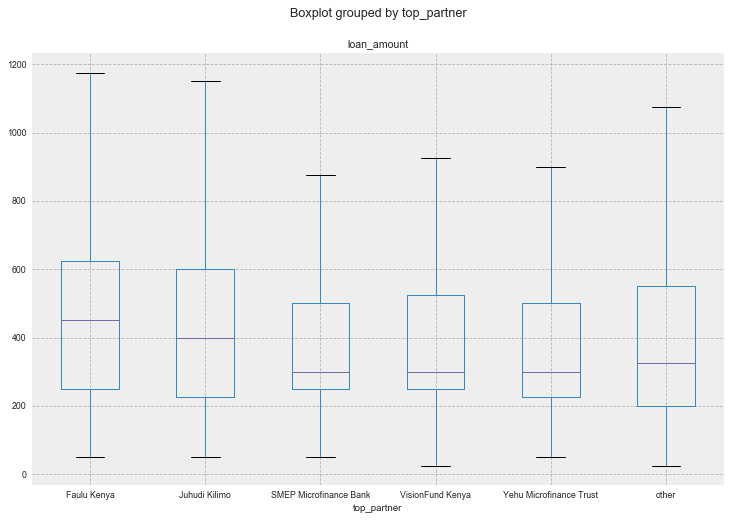

In [119]:
df[(df['borrower_count'] == 1)].boxplot(column='loan_amount', by='top_partner', showfliers=False, figsize=(12,8))

In [120]:
df.head(2)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,activity,basket_amount,bonus_credit_eligibility,borrowers,currency_exchange_loss_amount,description.languages,description.texts.en,description.texts.es,description.texts.fr,description.texts.ru,funded_amount,funded_date,id,image.id,image.template_id,journal_totals.bulkEntries,journal_totals.entries,lender_count,loan_amount,location.country,location.country_code,location.geo.level,location.geo.pairs,location.geo.type,location.town,name,partner_id,payments,planned_expiration_date,posted_date,sector,status,tags,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,terms.local_payments,terms.loss_liability.currency_exchange,terms.loss_liability.currency_exchange_coverage_rate,terms.loss_liability.nonpayment,terms.repayment_interval,terms.repayment_term,terms.scheduled_payments,themes,translator.byline,translator.image,...,funded_datetime,dispursal_datetime,dispersal_date,posted_year,number_of_loans,gender,num_tags,tag_#Woman Owned Biz,tag_#Parent,tag_user_favorite,tag_#Repeat Borrower,tag_#Schooling,tag_volunteer_pick,tag_#Vegan,tag_volunteer_like,tag_#Animals,tag_#Eco-friendly,tag_#Technology,widowed,kids,elderly,repeat_borrower,married,age,children_1,children_2,children_int_1,children_int_2,age_int,children_int,age_bucket,location,location_detail,location_str,county,province,province_capital,time_to_fund,days_to_fund,time_to_expire_datetime,days_to_expire,posted_month,time_to_dispersal,days_to_dispersal,posted_date_unix,num_partner_countries,more_one_partner_country,us_partner,top_partner_id,top_partner
7,7,7,21,Celebrations,NaN,False,"[{'first_name': 'Naomi', 'last_name': '', 'gen...",NaN,['en'],Naomi is a single mother of 2 children and she...,NaN,NaN,NaN,100,2017-05-08,1291404,2515811,1,0,0,4,100,Kenya,KE,town,1 38,point,nyeri,Naomi,386.0,[],2017-06-07,2017-05-08,Personal Use,funded,"[{'name': '#Animals'}, {'name': '#Parent'}, {'...",10000.0,KES,2017-04-03T07:00:00Z,100,[],shared,0.1,lender,NaN,5,[],NaN,Cheryl Strecker,1412668.0,...,2017-05-08 23:01:45,2017-04-03 07:00:00,2017-04-03,2017,1,Female,2,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,,,2 children,NaN,2.0,29.560149,2.0,NaN,nyeri kenya,"(Nyeri, Kenya, (-0.3167549, 36.9310063554392))","nyeri,",nyeri,central,nyeri,00:51:40,0.0,30 days 00:00:00,30.0,5,-36 days +08:49:55,-36,1.494191e+09,1,0,0,1.0,other
14,14,14,95,Beauty Salon,NaN,False,"[{'first_name': 'Tabitha', 'last_name': '', 'g...",NaN,['en'],Tabitha is a single mother of one child. She i...,NaN,NaN,NaN,100,2017-05-07,1290591,2514760,1,0,0,4,100,Kenya,KE,town,1 38,point,Muranga,Tabitha,386.0,[],2017-06-06,2017-05-07,Services,funded,"[{'name': '#Woman Owned Biz'}, {'name': '#Pare...",10000.0,KES,2017-04-24T07:00:00Z,100,[],shared,0.1,lender,NaN,14,[],NaN,NaN,NaN,...,2017-05-07 23:31:21,2017-04-24 07:00:00,2017-04-24,2017,1,Female,2,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,,,,NaN,NaN,29.560149,0.0,NaN,muranga kenya,"(Murang`a, Kenya, (-0.83091505, 37.00486124961...","murang`a,",,Missing,NaN,03:51:13,0.0,29 days 23:59:59,29.0,5,-14 days +11:19:52,-14,1.494104e+09,1,0,0,1.0,other


We have been doing a lot of feature engineering work. Every additional feature we create takes up space. Let's do some cleanup of features we know we will not be using so that we can save storage space. We will call this dataframe abridged.

In [121]:
df=df.drop(['basket_amount','bonus_credit_eligibility','borrowers','currency_exchange_loss_amount', \
          'description.languages','description.texts.es','description.texts.fr','description.texts.ru','image.id','image.template_id',\
            'journal_totals.bulkEntries','journal_totals.entries','location.country','location.country_code',\
            'location.geo.level','name','payments','terms.local_payments','terms.loss_liability.currency_exchange',\
            'terms.loss_liability.currency_exchange_coverage_rate','terms.repayment_interval','terms.scheduled_payments',\
            'themes','translator.byline','translator.image','use','partner_url',\
         'location.country', 'location.geo.pairs','location.geo.type','partner_default_rate_note','partner_image.id', \
         'children_1', 'children_2', 'children_int_1', 'children_int_2'], axis=1)

In [ ]:
df.to_csv(data_path+'df_abridged.csv')

## Next Steps

Next, we will take our data and start doing some initial experimentation with model choice.